In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
import holidays
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from kerastuner import HyperModel, RandomSearch
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
%matplotlib inline

C:\Users\sakif\AppData\Local\Temp\ipykernel_30952\1259587078.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


In [2]:
# Load the weather and energy datasets
weather_data = pd.read_csv("weather_data.csv", index_col="DateTime", parse_dates=True)
energy_data = pd.read_csv("energy_data.csv", index_col="DateTime", parse_dates=True)

weather_data = weather_data[['DewPointC', 'FeelsLikeC',
       'HeatIndexC','pressure','humidity']]
energy_data = energy_data[['Total (MW)']]


In [3]:
# Assuming you have weather_df and energy_df as DataFrames
merged_df = pd.merge(weather_data, energy_data, on='DateTime')
merged_df.reset_index(inplace=True)
df = merged_df

In [4]:
df['DateTime']=pd.to_datetime(df['DateTime']) 
#DatetimeIndex, which is a pandas index that is optimized to index data with dates and times.
df['year'] = df['DateTime'].apply(lambda x: x.year)
df['quarter'] = df['DateTime'].apply(lambda x: x.quarter)
df['month'] = df['DateTime'].apply(lambda x: x.month)
df['day'] = df['DateTime'].apply(lambda x: x.day)
df['hour'] = df['DateTime'].dt.hour
df.sort_values('DateTime', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['Working_day'] = np.where(df['dayofweek'].isin([0,1,2,3,6]), 1, 0)

In [5]:
# Define business hours in Bangladesh
business_hours_start = 9
business_hours_end = 17
lunch_break_start = 13
lunch_break_end = 14

# Define a function to check if a given time is within business hours
def is_business_hour(dt):
    if dt.weekday() in [0, 1, 2, 3, 6] and (business_hours_start <= dt.hour < business_hours_end) and not (lunch_break_start <= dt.hour < lunch_break_end):
        return 1
    else:
        return 0

# Apply the function to create the 'is_business_hour' feature
df['is_business_hour'] = df['DateTime'].apply(is_business_hour)

In [6]:
# Define peak hours in Bangladesh (e.g., 6-9 AM and 5-8 PM)
peak_hours_start1 = 6
peak_hours_end1 = 9
peak_hours_start2 = 17
peak_hours_end2 = 20

# Define a function to check if a given time is within peak hours
def is_peak_hour(dt):
    if (peak_hours_start1 <= dt.hour < peak_hours_end1) or (peak_hours_start2 <= dt.hour < peak_hours_end2):
        return 1
    else:
        return 0

# Apply the function to create the 'is_peak_hour' feature
df['is_peak_hour'] = df['DateTime'].apply(is_peak_hour)

# Create 'time_of_day' categorical feature
time_of_day_bins = [0, 6, 12, 18, 24]
time_of_day_labels = ['night', 'morning', 'afternoon', 'evening']
df['time_of_day'] = pd.cut(df['DateTime'].dt.hour, bins=time_of_day_bins, labels=time_of_day_labels, right=False, include_lowest=True)


In [7]:
df.columns

Index(['DateTime', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'pressure',
       'humidity', 'Total (MW)', 'year', 'quarter', 'month', 'day', 'hour',
       'dayofweek', 'Working_day', 'is_business_hour', 'is_peak_hour',
       'time_of_day'],
      dtype='object')

In [8]:
df_c = df
df=df.loc[:,['DateTime', 'DewPointC', 'FeelsLikeC',
       'HeatIndexC','pressure','humidity', 'Total (MW)', 'year', 'quarter', 'month',
       'day', 'hour', 'dayofweek', 'Working_day', 'is_business_hour',
       'is_peak_hour', 'time_of_day']]

In [9]:
print(df.shape)
print(df.DateTime.min())
print(df.DateTime.max())

(43824, 17)
2018-01-01 00:00:00
2022-12-31 23:00:00


In [10]:
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Define a custom holiday calendar for Bangladesh
class BangladeshHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('International Mother Language Day', month=2, day=21),
        Holiday('Sheikh Mujibur Rahman\'s birthday', month=3, day=17),
        Holiday('Independence Day', month=3, day=26),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Eid al-Fitr', month=1, day=1, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('National Mourning Day', month=8, day=15),
        Holiday('Eid al-Adha', month=8, day=22, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Ashura', month=1, day=1, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Durga Puja', month=10, day=16, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Victory Day', month=12, day=16),
        Holiday('Christmas Day', month=12, day=25)
    ]

# Create a custom business day offset that excludes holidays in Bangladesh
bangladesh_busday = CustomBusinessDay(calendar=BangladeshHolidayCalendar())

# Create a new column 'Holiday' and initialize with 0
df['Holiday'] = 0

# Set the 'Holiday' column to 1 for the dates that are holidays in Bangladesh
for holiday in BangladeshHolidayCalendar().holidays(start='2018-01-01', end='2022-12-31'):
    df.loc[df['DateTime'].dt.date == holiday.date(), 'Holiday'] = 1
df

,DateTime,DewPointC,FeelsLikeC,HeatIndexC,pressure,humidity,Total (MW),year,quarter,month,day,hour,dayofweek,Working_day,is_business_hour,is_peak_hour,time_of_day,Holiday
0,2018-01-01 00:00:00,13,25,25,1012,55,5673.00,2018,1,1,1,0,0,1,0,0,night,1
1,2018-01-01 01:00:00,14,25,25,1012,56,5183.00,2018,1,1,1,1,0,1,0,0,night,1
2,2018-01-01 02:00:00,15,25,25,1011,57,4908.00,2018,1,1,1,2,0,1,0,0,night,1
3,2018-01-01 03:00:00,16,26,26,1011,58,4786.00,2018,1,1,1,3,0,1,0,0,night,1
4,2018-01-01 04:00:00,15,25,25,1011,59,4599.00,2018,1,1,1,4,0,1,0,0,night,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2022-12-31 19:00:00,8,23,23,1016,39,9581.00,2022,4,12,31,19,5,0,0,1,evening,0
43820,2022-12-31 20:00:00,8,22,22,1016,40,9396.00,2022,4,12,31,20,5,0,0,0,evening,0
43821,2022-12-31 21:00:00,7,20,20,1017,42,9088.00,2022,4,12,31,21,5,0,0,0,evening,0
43822,2022-12-31 22:00:00,7,19,19,1017,44,8697.00,2022,4,12,31,22,5,0,0,0,evening,0


In [11]:
df.set_index('DateTime', inplace = True)

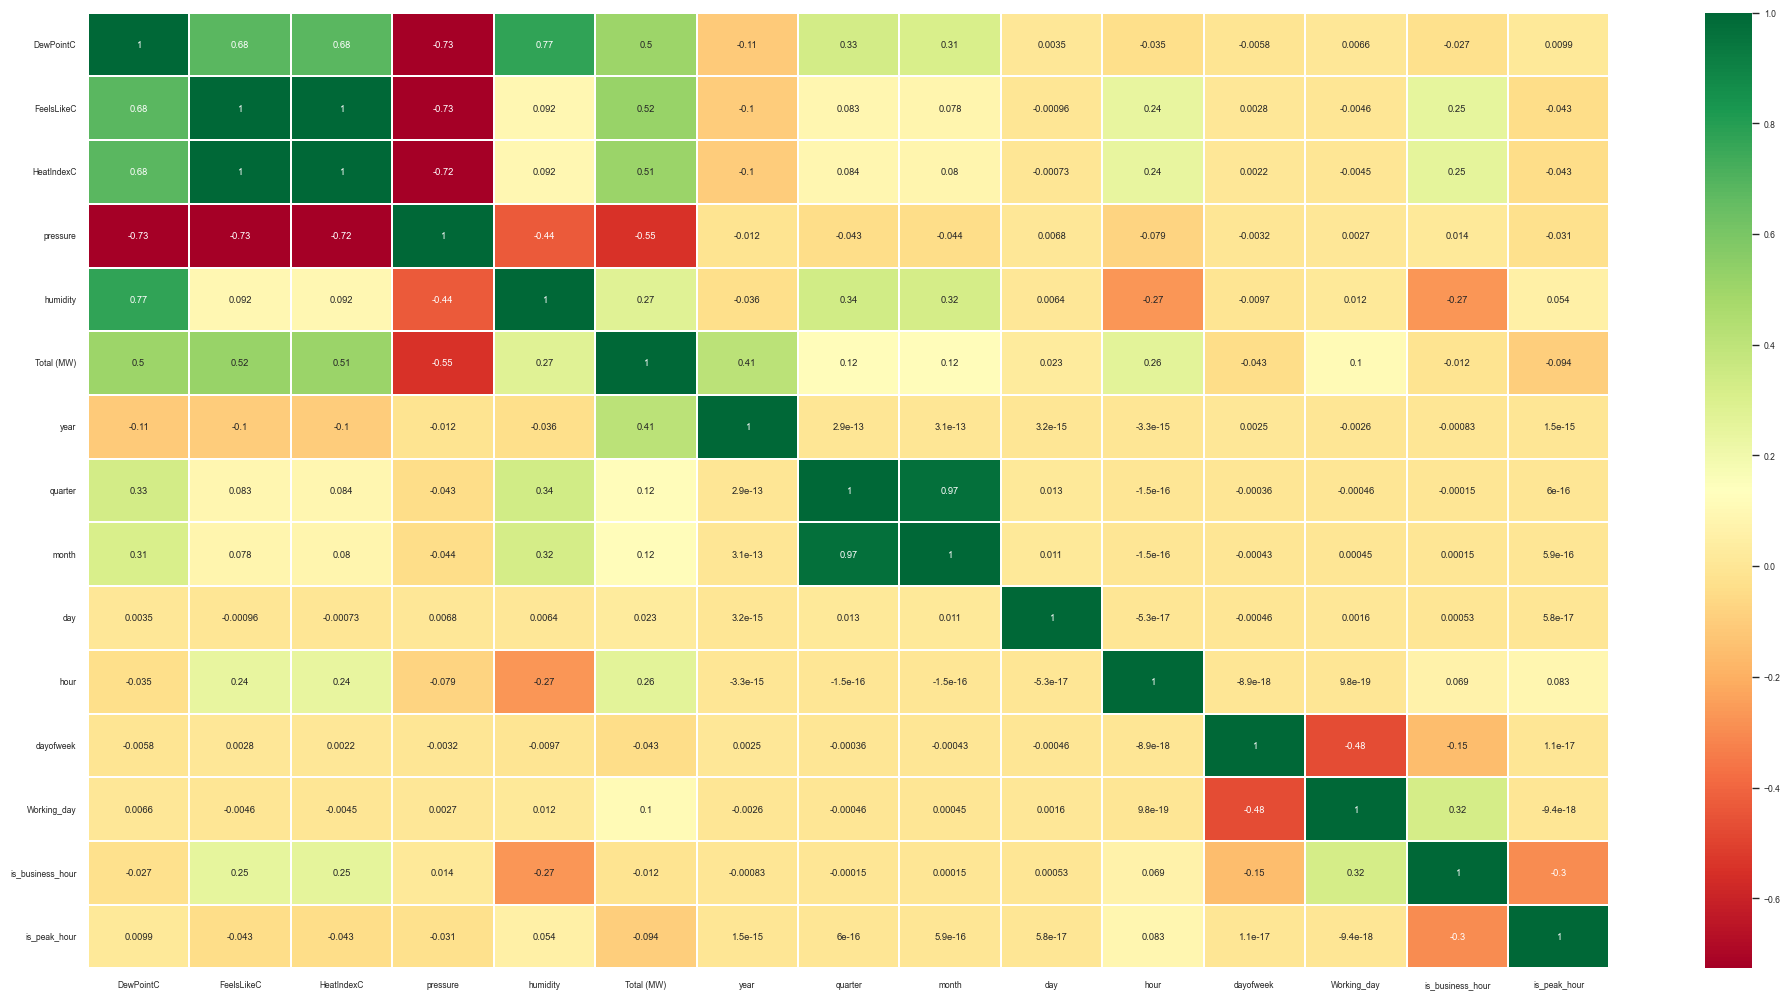

In [12]:
sns.set_style('white')
sns.set_context("paper", font_scale=0.7)  
plt.figure(figsize=(20,10))
sns.heatmap(df_c.corr(), annot=True, cmap='RdYlGn', linewidths=0.1)
plt.tight_layout()

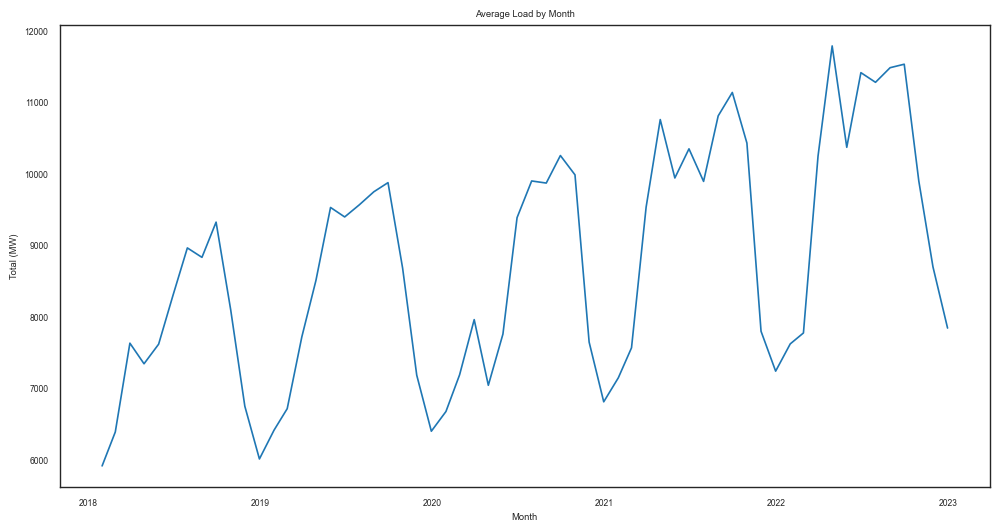

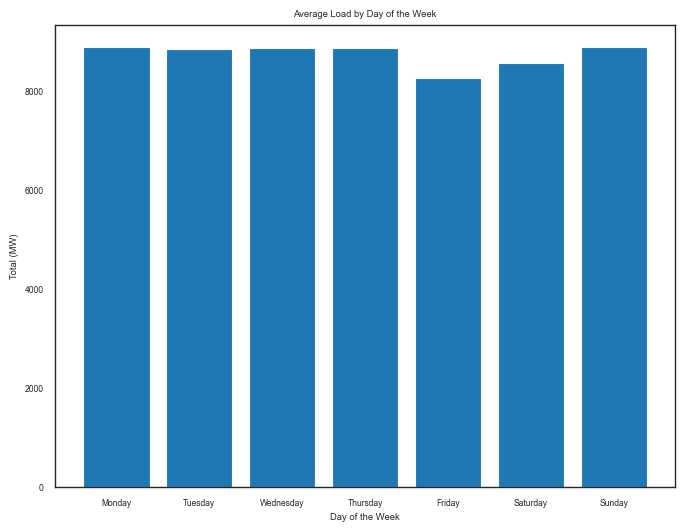

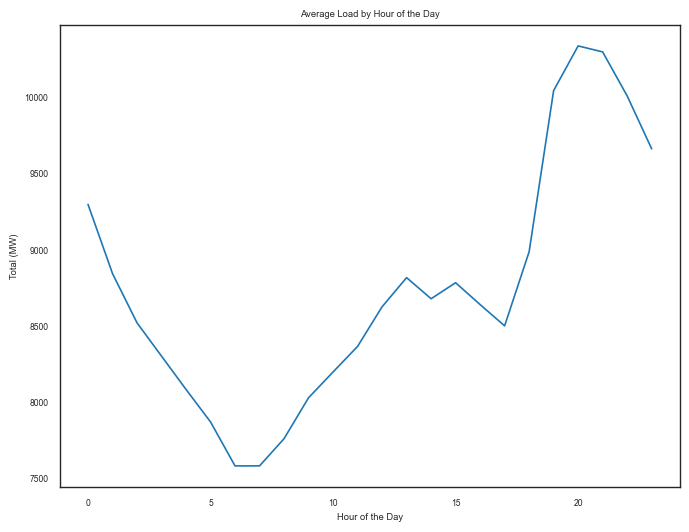

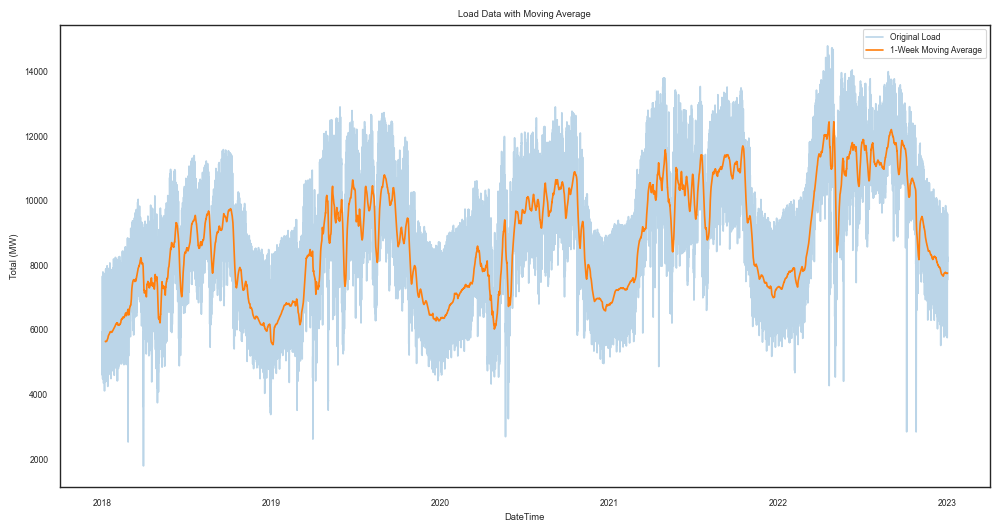

In [16]:
df.reset_index(inplace=True)
# Assuming the merged dataset is stored in a DataFrame called 'data'
# Make sure the 'DateTime' column is of datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set the 'DateTime' column as the index
df.set_index('DateTime', inplace=True)

# a. Seasonal patterns: Average load by month
monthly_data = df.resample('M').mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Total (MW)'])
plt.title('Average Load by Month')
plt.xlabel('Month')
plt.ylabel('Total (MW)')
plt.show()

# b. Weekly patterns: Average load by day of the week
weekday_data = df.groupby(df.index.dayofweek)['Total (MW)'].mean()
plt.figure(figsize=(8, 6))
plt.bar(weekday_data.index, weekday_data)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Load by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total (MW)')
plt.show()

# c. Daily patterns: Average load by hour of the day
hourly_data = df.groupby(df.index.hour)['Total (MW)'].mean()
plt.figure(figsize=(8, 6))
plt.plot(hourly_data.index, hourly_data)
plt.title('Average Load by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total (MW)')
plt.show()

# d. Trend analysis: Moving average
df['moving_average'] = df['Total (MW)'].rolling(window=24*7).mean()  # 1-week moving average
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Total (MW)'], alpha=0.3, label='Original Load')
plt.plot(df.index, df['moving_average'], label='1-Week Moving Average')
plt.title('Load Data with Moving Average')
plt.xlabel('DateTime')
plt.ylabel('Total (MW)')
plt.legend()
plt.show()


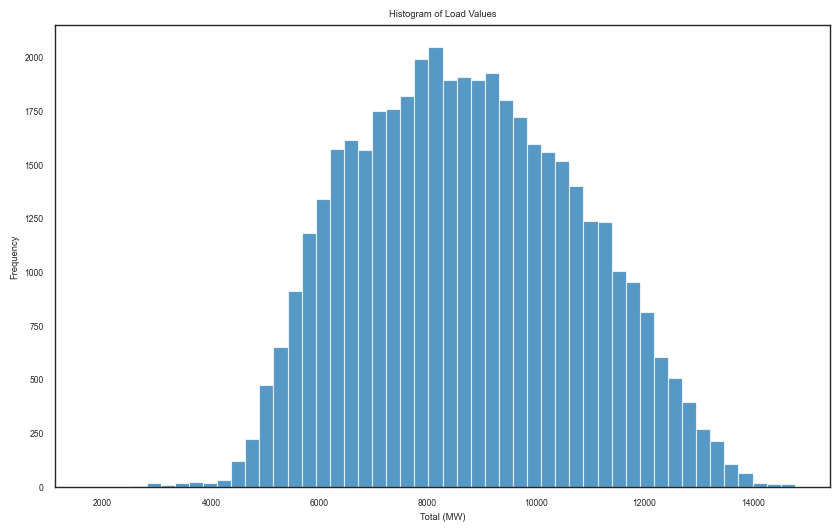

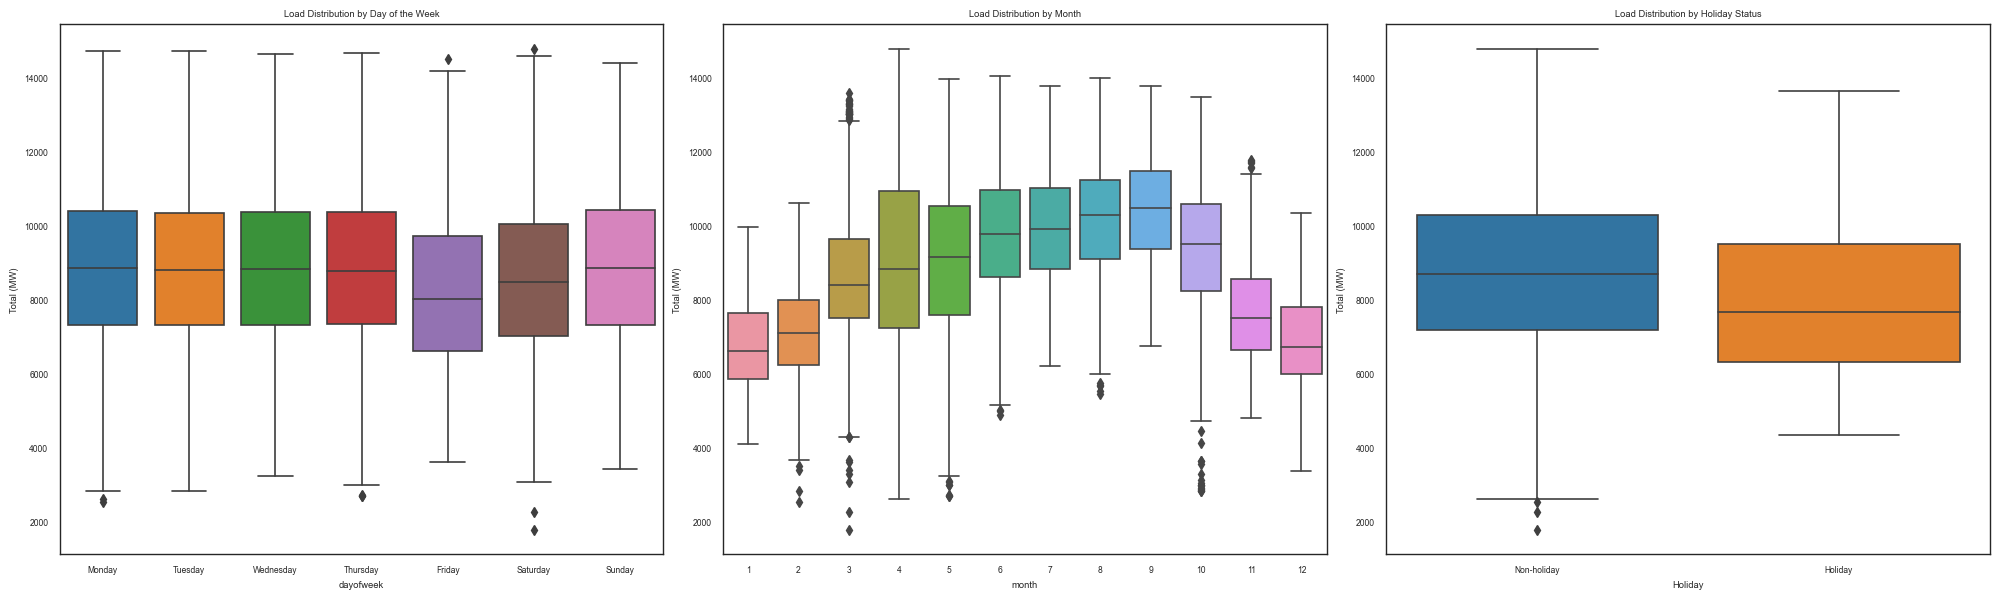

In [14]:
# a. Histograms of the load values
plt.figure(figsize=(10, 6))
plt.hist(df['Total (MW)'], bins=50, alpha=0.75)
plt.title('Histogram of Load Values')
plt.xlabel('Total (MW)')
plt.ylabel('Frequency')
plt.show()

# b. Box plots of the load values by categorical features
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# By day of the week
sns.boxplot(x='dayofweek', y='Total (MW)', data=df, ax=axes[0])
axes[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[0].set_title('Load Distribution by Day of the Week')

# By month
sns.boxplot(x='month', y='Total (MW)', data=df, ax=axes[1])
axes[1].set_title('Load Distribution by Month')

# By holiday status
sns.boxplot(x='Holiday', y='Total (MW)', data=df, ax=axes[2])
axes[2].set_xticklabels(['Non-holiday', 'Holiday'])
axes[2].set_title('Load Distribution by Holiday Status')

plt.tight_layout()
plt.show()


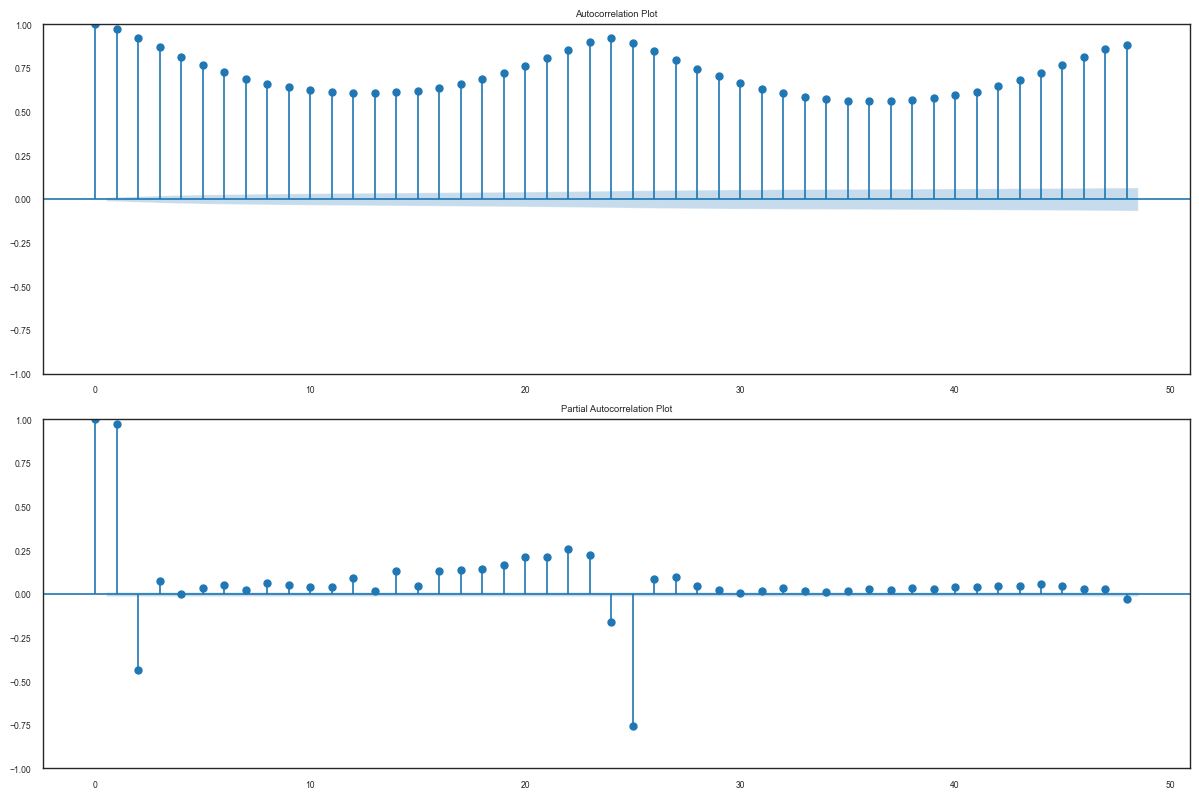

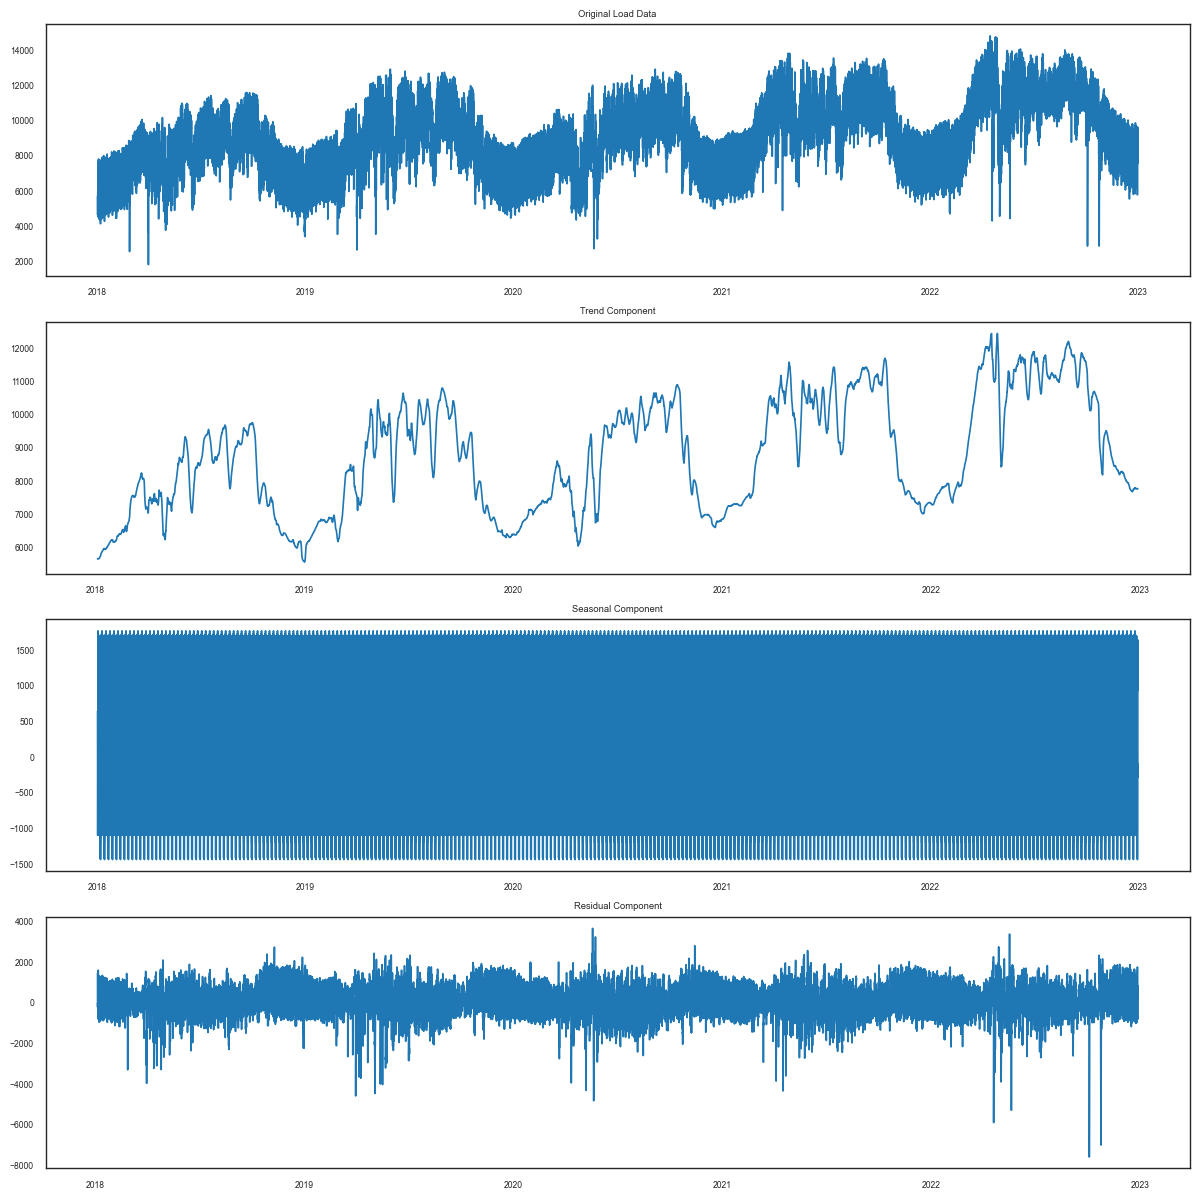

In [15]:
df.reset_index(inplace=True)
# Make sure the 'DateTime' column is of datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set the 'DateTime' column as the index
df.set_index('DateTime', inplace=True)

# Autocorrelation and partial autocorrelation plots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

plot_acf(df['Total (MW)'], lags=48, ax=axes[0])
axes[0].set_title('Autocorrelation Plot')

plot_pacf(df['Total (MW)'], lags=48, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Plot')

plt.tight_layout()
plt.show()

# Decomposition of the time series
decomposition = seasonal_decompose(df['Total (MW)'], model='additive', period=24*7)  # Weekly seasonality
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))
axes[0].plot(df['Total (MW)'])
axes[0].set_title('Original Load Data')

axes[1].plot(trend)
axes[1].set_title('Trend Component')

axes[2].plot(seasonal)
axes[2].set_title('Seasonal Component')

axes[3].plot(residual)
axes[3].set_title('Residual Component')

plt.tight_layout()
plt.show()


In [17]:
df.reset_index(inplace=True)


## k-means Clustering ##

In [31]:

# Prepare the dataset for clustering
daily_data = df.pivot_table(values='Total (MW)', index=df['DateTime'].dt.date, columns=df['DateTime'].dt.hour)

# Normalize the data
scaler = StandardScaler()
daily_data_scaled = scaler.fit_transform(daily_data)

# Determine the optimal number of clusters
cluster_range = range(2, 11)  # Test different numbers of clusters, e.g., from 2 to 10
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(daily_data_scaled)
    silhouette_avg = silhouette_score(daily_data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]

# Fit the k-means clustering algorithm with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
daily_data['cluster'] = kmeans.fit_predict(daily_data_scaled)
labels = kmeans.labels_
daily_data['cluster'] = labels
labels = kmeans.labels_

# Add a column with cluster labels to the original dataset
daily_data['cluster'] = labels

# Investigate the characteristics of each cluster
for cluster in range(optimal_clusters):
    cluster_days = daily_data[daily_data['cluster'] == cluster]
    print(f"Cluster {cluster}: {len(cluster_days)} days")
    print(cluster_days.describe().transpose())
    print()


Cluster 0: 995 days
          count    mean     std     min     25%     50%     75%      max
DateTime                                                                
0        995.00 7527.41 1327.64 3033.00 6585.50 7323.00 8341.00 13923.00
1        995.00 7042.49 1315.75 2983.00 6087.00 6807.00 7810.00 13476.00
2        995.00 6729.37 1287.35 2883.00 5799.00 6475.00 7493.00 12633.00
3        995.00 6522.49 1261.06 2828.00 5642.50 6270.00 7256.00 11905.00
4        995.00 6329.93 1210.63 2857.00 5483.00 6074.00 7025.00 10697.00
5        995.00 6178.06 1125.47 2515.00 5420.00 5983.00 6893.50 10103.00
6        995.00 6171.86  899.28 2679.20 5598.00 6090.00 6762.55  9610.00
7        995.00 6369.70  820.03 1774.00 5870.20 6404.70 6920.50  9533.00
8        995.00 6695.31  810.21 2256.00 6186.70 6767.02 7252.50  9683.00
9        995.00 6957.69  860.57 3286.00 6395.09 7035.00 7567.70  9694.00
10       995.00 7044.97  903.91 3538.40 6397.70 7118.90 7738.20  9923.00
11       995.00 7176.18  933.02

From the clustering results, it appears that the daily load profiles have been grouped into two distinct clusters (Cluster 0 and Cluster 1). These clusters represent two different types of daily load patterns. Let's analyze the characteristics of each cluster:

**Cluster 0:**

1. This cluster has 995 days.
2. The average load in this cluster is generally lower throughout the day compared to Cluster 1.
3. The peak load hours are between 18:00 and 21:00, with the highest average load around 20:00.
4. The minimum load hours are between 4:00 and 6:00, with the lowest average load around 5:00.

**Cluster 1:**

1. This cluster has 831 days.
2. The average load in this cluster is generally higher throughout the day compared to Cluster 0.
3. The peak load hours are between 18:00 and 22:00, with the highest average load around 21:00.
4. The minimum load hours are between 4:00 and 6:00, with the lowest average load around 5:00.

Based on these observations, you can infer the following:

**Cluster 0** likely represents days with lower overall electricity demand, possibly corresponding to weekends, holidays, or off-peak seasons.

**Cluster 1** likely represents days with higher overall electricity demand, possibly corresponding to weekdays, non-holidays, or peak seasons.

Both clusters exhibit similar daily patterns, with the minimum load occurring early in the morning and the peak load in the evening. This suggests that the overall daily load pattern is consistent across different types of days, even though the demand levels may vary.

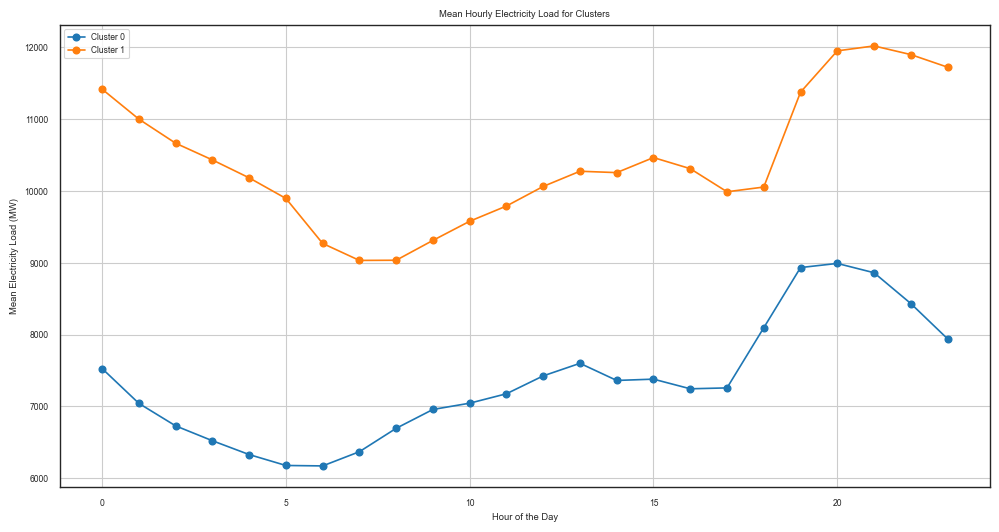

In [32]:
# Calculate the mean hourly load demand for each cluster
cluster_mean_load = daily_data.groupby('cluster').mean()

# Create a plot comparing the mean hourly load demand for each cluster
plt.figure(figsize=(12, 6))
plt.plot(cluster_mean_load.columns, cluster_mean_load.loc[0], label='Cluster 0', marker='o')
plt.plot(cluster_mean_load.columns, cluster_mean_load.loc[1], label='Cluster 1', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Electricity Load (MW)')
plt.title('Mean Hourly Electricity Load for Clusters')
plt.legend()
plt.grid()
plt.show()


In [33]:
weather_data = pd.read_csv("weather_data.csv", index_col="DateTime", parse_dates=True)
weather_data = weather_data.resample('D').mean()
weather_data = weather_data[['DewPointC', 'FeelsLikeC',
       'HeatIndexC','pressure','humidity']]

In [34]:
daily_data = daily_data.merge(weather_data, left_index=True, right_index=True)


In [35]:
# Add a column with cluster labels to the original dataset
# Assume 'labels' is the array containing the cluster labels (0 or 1) for each day
daily_data['cluster'] = labels

# Convert the index to DatetimeIndex
daily_data.index = pd.to_datetime(daily_data.index)

# Define the function to get the season based on the month
def get_season(month):
    if month in [2, 3, 4, 5]:
        return 'Irrigation'
    elif month in [4, 5, 6, 7]:
        return 'Summer'
    elif month in [12, 1, 2]:
        return 'Winter'
    elif month in [6, 7, 8, 9]:
        return 'Business'

# Extract the month from the 'DateTime' column
daily_data['month'] = daily_data.index.month

# Create a 'season' column based on the month
daily_data['season'] = daily_data.index.month.map(get_season)

# Create a custom business day offset that excludes holidays in Bangladesh
bangladesh_busday = CustomBusinessDay(calendar=BangladeshHolidayCalendar())

# Create a new column 'Holiday' and initialize with 0
daily_data['Holiday'] = 0

# Set the 'Holiday' column to 1 for the dates that are holidays in Bangladesh
for holiday in BangladeshHolidayCalendar().holidays(start='2018-01-01', end='2022-12-31'):
    daily_data.loc[daily_data.index.date == holiday.date(), 'Holiday'] = 1


In [36]:
# Analyze the distribution of days within each cluster across months
monthly_distribution = daily_data.groupby(['cluster', 'month']).size().unstack()
print("Distribution of days across months:")
print(monthly_distribution)

# Analyze the distribution of days within each cluster across weekdays and weekends
daily_data['weekday'] = daily_data.index.weekday
daily_data['weekend'] = daily_data['weekday'].apply(lambda x: 1 if x in ([0,1,2,3,6]) else 0)
weekend_distribution = daily_data.groupby(['cluster', 'weekend']).size().unstack()
print("\nDistribution of days across weekdays and weekends:")
print(weekend_distribution)

# Analyze the distribution of days within each cluster across seasons
season_distribution = daily_data.groupby(['cluster', 'season']).size().unstack()
print("Distribution of days across seasons:")
print(season_distribution)

# Analyze the distribution of days within each cluster across holidays
holiday_distribution = daily_data.groupby(['cluster', 'Holiday']).size().unstack()
print("\nDistribution of days across holidays:")
print(holiday_distribution)



Distribution of days across months:
month       1      2      3     4     5      6      7      8      9      10  \
cluster                                                                       
0       155.00 140.00 101.00 80.00 71.00  40.00  31.00  24.00  11.00  49.00   
1          NaN   1.00  54.00 70.00 84.00 110.00 124.00 131.00 139.00 106.00   

month       11     12  
cluster                
0       138.00 155.00  
1        12.00    NaN  

Distribution of days across weekdays and weekends:
weekend    0    1
cluster          
0        313  682
1        209  622
Distribution of days across seasons:
season   Business  Irrigation  Summer  Winter
cluster                                      
0           35.00      392.00   71.00  310.00
1          270.00      209.00  234.00     NaN

Distribution of days across holidays:
Holiday    0   1
cluster         
0        959  36
1        812  19


Based on the results, we can infer the following:

**Distribution of days across months:**

Cluster 0 is more frequent in months 1, 2, 11, and 12, with the highest occurrences in January (155) and December (155).

Cluster 1 is more frequent from March to September, peaking in July (124) and August (131).

Cluster 1 is almost absent in January and December.


**Distribution of days across weekdays and weekends:**

Cluster 0 has 313 occurrences on weekdays and 682 on weekends.

Cluster 1 has 209 occurrences on weekdays and 622 on weekends.

Both clusters occur more frequently on weekends than weekdays, with Cluster 0 being slightly more prevalent on weekends compared to Cluster 1.


**Distribution of days across seasons:**

Cluster 0 is most frequent in the Irrigation season (392) and Winter (310), while it is less frequent in Business (35) and Summer (71) seasons.

Cluster 1 is most frequent in the Business (270) and Summer (234) seasons, while it is less frequent in the Irrigation season (209). Cluster 1 is not present in Winter.

The seasonality of each cluster is distinct, with Cluster 0 being more common during the Irrigation and Winter seasons, and Cluster 1 during the Business and Summer seasons.


**Distribution of days across holidays:**

Cluster 0 has 959 occurrences on non-holidays and 36 on holidays.

Cluster 1 has 812 occurrences on non-holidays and 19 on holidays.

Both clusters are more frequent on non-holidays than on holidays. The difference in occurrences on holidays and non-holidays is more significant in Cluster 1.

In conclusion, Cluster 0 is more common during the Irrigation and Winter seasons, with a higher frequency on weekends and non-holidays. Cluster 1 is more common during the Business and Summer seasons, also with a higher frequency on weekends and non-holidays. However, the difference between holidays and non-holidays is more prominent in Cluster 1.

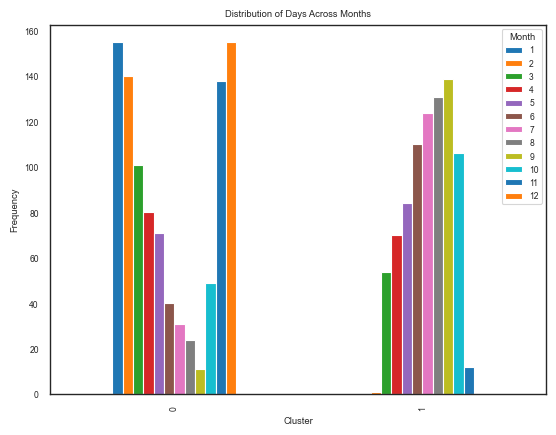

In [37]:
monthly_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Days Across Months')
plt.legend(title='Month')
plt.show()


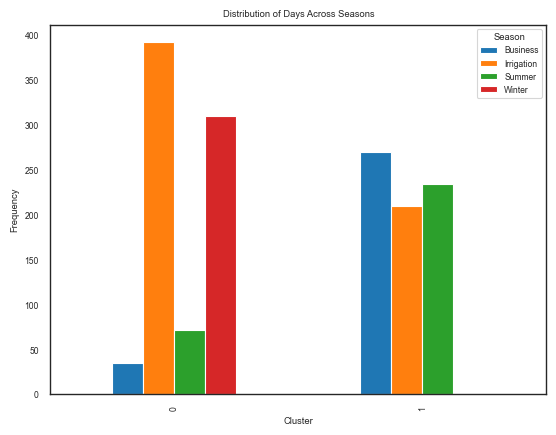

In [38]:
season_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Days Across Seasons')
plt.legend(title='Season')
plt.show()


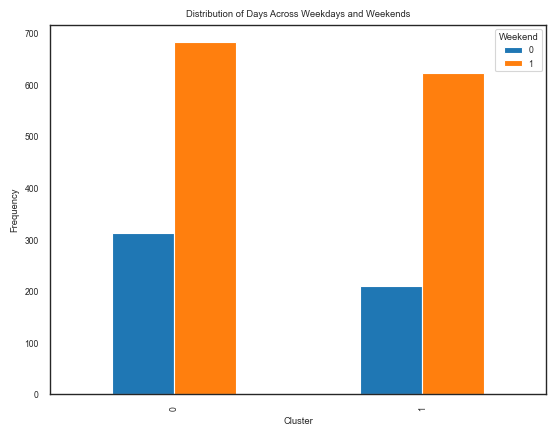

In [39]:
weekend_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Days Across Weekdays and Weekends')
plt.legend(title='Weekend')
plt.show()


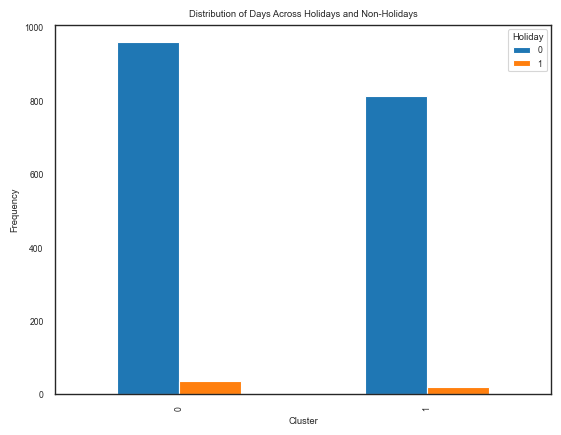

In [40]:
holiday_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Days Across Holidays and Non-Holidays')
plt.legend(title='Holiday')
plt.show()


In [43]:
daily_data.columns

Index([                  0,                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,                  10,                  11,
                        12,                  13,                  14,
                        15,                  16,                  17,
                        18,                  19,                  20,
                        21,                  22,                  23,
                 'cluster',         'DewPointC',        'FeelsLikeC',
              'HeatIndexC',          'pressure',          'humidity',
                   'month',           'Holiday',           'weekday',
                 'weekend',   'season_Business', 'season_Irrigation',
           'season_Summer',     'season_Winter'],
      dtype='object')

In [42]:
# Remove the 'DateTime' index name
daily_data.index.name = None

# Convert the 'season' column to a one-hot encoding format
daily_data = pd.get_dummies(daily_data, columns=['season'], prefix='season')

# Preprocess the data
scaler = StandardScaler()
daily_data_scaled = scaler.fit_transform(daily_data)

# Split the data into training and validation sets
X_train, X_val, train_idx, val_idx = train_test_split(daily_data_scaled, np.arange(daily_data.shape[0]), test_size=0.2, random_state=42)

# Define a HyperModel class for the autoencoder
class AutoencoderHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        input_layer = Input(shape=(self.input_dim,))
        encoder = Dense(
            hp.Int("encoder_units", min_value=16, max_value=64, step=8),
            activation="relu",
        )(input_layer)
        decoder = Dense(self.input_dim, activation="linear")(encoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer="adam", loss="mean_squared_error")

        return autoencoder

# Create the hypermodel instance
hypermodel = AutoencoderHyperModel(input_dim=X_train.shape[1])

# Initialize the random search tuner
tuner = RandomSearch(
    hypermodel,
    objective="val_loss",
    max_trials=10,  # You can change this value based on available resources
    seed=42,
    directory="random_search",
)

# Search for the best hyperparameters
tuner.search(
    x=X_train,
    y=X_train,
    epochs=100,
    validation_data=(X_val, X_val),
    batch_size=32,
    shuffle=True,
)

# Get the best model and train it
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_val, X_val))

# Reconstruct the data and calculate the reconstruction errors
X_train_pred = best_model.predict(X_train)
X_val_pred = best_model.predict(X_val)
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
mse_val = np.mean(np.power(X_val - X_val_pred, 2), axis=1)

# Determine the threshold for anomalies
threshold = np.percentile(np.concatenate([mse_train, mse_val]), 99)  # 99th percentile

# Detect anomalies
train_anomalies = X_train[mse_train > threshold]
val_anomalies = X_val[mse_val > threshold]

print("Number of anomalies in the training set:", len(train_anomalies))
print("Number of anomalies in the validation set:", len(val_anomalies))

INFO:tensorflow:Reloading Tuner from random_search\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


ValueError: Received incompatible tensor with shape (33, 64) when attempting to restore variable with shape (38, 64) and name layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE.

In [ ]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-01-01 to 2022-12-31
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   0                  1826 non-null   float64
 1   1                  1826 non-null   float64
 2   2                  1826 non-null   float64
 3   3                  1826 non-null   float64
 4   4                  1826 non-null   float64
 5   5                  1826 non-null   float64
 6   6                  1826 non-null   float64
 7   7                  1826 non-null   float64
 8   8                  1826 non-null   float64
 9   9                  1826 non-null   float64
 10  10                 1826 non-null   float64
 11  11                 1826 non-null   float64
 12  12                 1826 non-null   float64
 13  13                 1826 non-null   float64
 14  14                 1826 non-null   float64
 15  15                 1826 non-null   float64
 16  16    

In [ ]:
# Define a HyperModel class for the autoencoder
class AutoencoderHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        input_layer = Input(shape=(self.input_dim,))
        encoder = Dense(
            hp.Int("encoder_units", min_value=16, max_value=64, step=8),
            activation="relu",
        )(input_layer)
        decoder = Dense(self.input_dim, activation="linear")(encoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer="adam", loss="mean_squared_error")

        return autoencoder


# Create the hypermodel instance
hypermodel = AutoencoderHyperModel(input_dim)

# Initialize the random search tuner
tuner = RandomSearch(
    hypermodel,
    objective="val_loss",
    max_trials=10,  # You can change this value based on available resources
    seed=42,
    directory="random_search",
)

# Search for the best hyperparameters
tuner.search(
    x=X_train,
    y=X_train,
    epochs=100,
    validation_data=(X_val, X_val),
    batch_size=32,
    shuffle=True,
)

# Get the best model and train it
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_val, X_val))

# Reconstruct the data and calculate the reconstruction errors
X_train_pred = best_model.predict(X_train)
X_val_pred = best_model.predict(X_val)
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
mse_val = np.mean(np.power(X_val - X_val_pred, 2), axis=1)

# Determine the threshold for anomalies
threshold = np.percentile(np.concatenate([mse_train, mse_val]), 99)  # 99th percentile

# Detect anomalies
train_anomalies = X_train[mse_train > threshold]
val_anomalies = X_val[mse_val > threshold]

print("Number of anomalies in the training set:", len(train_anomalies))
print("Number of anomalies in the validation set:", len(val_anomalies))


INFO:tensorflow:Reloading Tuner from random_search\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


ValueError: Received incompatible tensor with shape (33, 64) when attempting to restore variable with shape (44, 64) and name layer_with_weights-0/kernel/.ATTRIBUTES/VARIABLE_VALUE.

In [ ]:

train_anomalies_indices = train_idx[np.where(mse_train > threshold)[0]]
val_anomalies_indices = val_idx[np.where(mse_val > threshold)[0]]

print("Anomalies in the training set:")
print(daily_data.iloc[train_anomalies_indices])



Anomalies in the training set:
                  0        1        2        3        4        5        6  \
2022-09-18 12763.00 12486.00 12518.00 12033.00 11712.00 11520.00 10897.00   
2019-03-17  9226.00  8644.00  8240.00  8060.00  7786.00  7646.00  7668.01   
2022-08-23 12097.00 11756.00 11377.00 11437.00 11393.00 11355.00 11050.00   
2020-10-23  8724.00  8327.00  9451.00  7699.00  7393.00  7146.00  6683.00   
2021-04-17 10854.00  9909.00  8668.00  8068.00  6116.00  5377.00  4950.00   
2021-04-21 12928.00 12279.00 11953.00 12048.00 11640.00 10844.00 10208.00   
2019-01-08  5939.00  5605.00  5176.00  5146.00  5060.00  4982.00  5174.00   
2018-12-14  6245.00  5633.00  5459.00  5235.00  5101.00  4967.00  5172.00   
2022-05-21 11783.00 11367.00 10837.00 10128.00  9083.00  8250.00  5153.00   
2022-10-24 10285.00  9759.00  9663.00  9494.00  9106.00  8704.00  8124.00   
2022-05-18 13038.00 12733.00 12312.00 12048.00 13760.00 11394.00 10616.00   

                  7        8        9  ...  

In [ ]:
print("\nAnomalies in the validation set:")
print(daily_data.iloc[val_anomalies_indices])


Anomalies in the validation set:
                  0        1        2        3        4        5        6  \
2019-09-02 12011.00 11325.00 10118.00 10330.00 10191.00 10202.00  9503.44   
2022-09-06 12247.00 11976.00 11874.00 11693.00 11611.00 11393.00 10705.00   
2018-12-18  5812.00  5179.00  4874.00  4483.00  4190.00  4022.00  4024.00   
2022-10-17 10911.00 10314.00 10151.00 10068.00  9826.00  9770.00  9601.00   
2022-04-23  9335.00  8885.00  8695.00  9096.00  8608.00  7813.00  7281.00   
2019-08-15  9210.00  8862.00  8466.00  8247.00  8107.00  7936.00  7261.08   
2020-03-17  8783.00  8253.00  7863.00  7617.00  7429.00  7295.00  7276.00   
2019-09-30  8674.00  8273.00  8071.00  7748.00  7396.00  7345.00  7098.00   

                  7        8       9  ...       23  cluster  month  Holiday  \
2019-09-02  8849.25  8888.90 9372.90  ... 11779.00        1      9        0   
2022-09-06 10615.00 10636.00 9749.00  ... 13342.00        1      9        0   
2018-12-18  4261.20  4909.50 5563.9

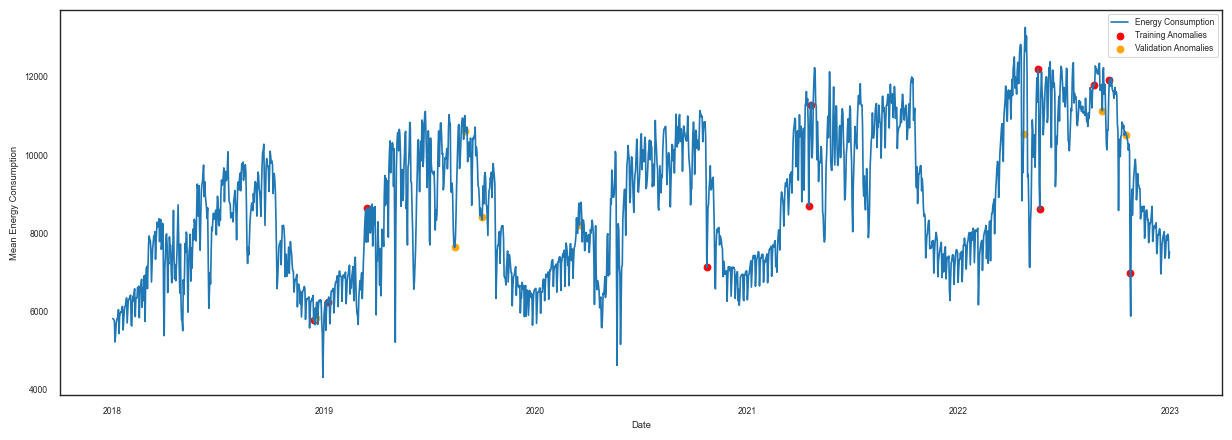

In [ ]:

# Plot energy consumption data (mean across all hours)
daily_data['mean_energy'] = daily_data.iloc[:, 0:24].mean(axis=1)
plt.figure(figsize=(15, 5))
plt.plot(daily_data.index, daily_data['mean_energy'], label='Energy Consumption')

# Mark the anomalies in the training set
train_anomalies_dates = daily_data.index[train_anomalies_indices]
plt.scatter(train_anomalies_dates, daily_data.loc[train_anomalies_dates, 'mean_energy'], color='red', label='Training Anomalies')

# Mark the anomalies in the validation set
val_anomalies_dates = daily_data.index[val_anomalies_indices]
plt.scatter(val_anomalies_dates, daily_data.loc[val_anomalies_dates, 'mean_energy'], color='orange', label='Validation Anomalies')

plt.xlabel('Date')
plt.ylabel('Mean Energy Consumption')
plt.legend()
plt.show()


In [ ]:
train_anomalies_dates = daily_data.index[train_anomalies_indices]
val_anomalies_dates = daily_data.index[val_anomalies_indices]

In [ ]:
daily_data.columns


Index([                  0,                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,                  10,                  11,
                        12,                  13,                  14,
                        15,                  16,                  17,
                        18,                  19,                  20,
                        21,                  22,                  23,
                 'cluster',             'month',           'Holiday',
                 'weekday',           'weekend',   'season_Business',
       'season_Irrigation',     'season_Summer',     'season_Winter',
             'mean_energy'],
      dtype='object')

In [ ]:
train_anomalies_dates

DatetimeIndex(['2022-09-18', '2019-03-17', '2022-08-23', '2020-10-23',
               '2021-04-17', '2021-04-21', '2019-01-08', '2018-12-14',
               '2022-05-21', '2022-10-24', '2022-05-18'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# Display the anomalies with the context columns
context_columns = ['cluster', 'month', 'weekday', 'weekend',  'Holiday', 'season_Business',
       'season_Irrigation',     'season_Summer',     'season_Winter']
anomalies_data = daily_data.loc[np.concatenate([train_anomalies_dates, val_anomalies_dates]), context_columns]

print("Anomalies with context:")
print(anomalies_data)


Anomalies with context:
            cluster  month  weekday  weekend  Holiday  season_Business  \
2022-09-18        1      9        6        1        0                1   
2019-03-17        0      3        6        1        1                0   
2022-08-23        1      8        1        1        1                1   
2020-10-23        0     10        4        0        0                0   
2021-04-17        0      4        5        0        0                0   
2021-04-21        1      4        2        1        0                0   
2019-01-08        0      1        1        1        0                0   
2018-12-14        0     12        4        0        0                0   
2022-05-21        0      5        5        0        0                0   
2022-10-24        0     10        0        1        0                0   
2022-05-18        1      5        2        1        0                0   
2019-09-02        1      9        0        1        0                1   
2022-09-06    

In [ ]:
context_columns = ['cluster', 'month', 'weekday', 'weekend', 'Holiday', 'season_Business', 'season_Irrigation', 'season_Summer', 'season_Winter']
context_counts = anomalies_data[context_columns].groupby(context_columns).size().reset_index(name='count')
print(context_counts)


    cluster  month  weekday  weekend  Holiday  season_Business  \
0         0      1        1        1        0                0   
1         0      3        1        1        1                0   
2         0      3        6        1        1                0   
3         0      4        5        0        0                0   
4         0      5        5        0        0                0   
5         0      8        3        1        1                1   
6         0      9        0        1        0                1   
7         0     10        0        1        0                0   
8         0     10        4        0        0                0   
9         0     12        1        1        0                0   
10        0     12        4        0        0                0   
11        1      4        2        1        0                0   
12        1      4        5        0        0                0   
13        1      5        2        1        0                0   
14        

1. Most of the anomalies (10 out of 19) are in cluster 0, suggesting that this cluster may have certain characteristics that lead to more frequent anomalies.
2. Anomalies seem to be more frequent during the Irrigation season (11 out of 19), which could indicate that energy consumption patterns are more volatile during this period.
3. There are no anomalies during the Summer and Winter seasons, suggesting that energy consumption during these seasons may be more stable and predictable.
4. Anomalies are more frequent on weekends (16 out of 19). This may imply that energy consumption patterns differ between weekdays and weekends, leading to more anomalies on weekends.
5. There are fewer anomalies (6 out of 19) on holidays, which could mean that energy consumption on holidays follows more or less predictable patterns.

In [ ]:
# Group the anomalies by cluster and calculate the mean values for each feature
cluster_means = anomalies_data.groupby('cluster').mean()

# Print the mean values for each feature, grouped by cluster
print(cluster_means)

         month  weekday  weekend  Holiday  season_Business  season_Irrigation  \
cluster                                                                         
0         7.00     2.73     0.64     0.27             0.18               0.36   
1         7.25     2.12     0.88     0.25             0.50               0.38   

         season_Summer  season_Winter  
cluster                                
0                 0.00           0.27  
1                 0.00           0.00  


We can make the following observations about the differences between the two clusters:

**month:** Cluster 0 has a slightly higher mean month value (6.80) than Cluster 1 (6.22). This indicates that anomalies in Cluster 0 are more likely to occur later in the year compared to those in Cluster 1.

**weekday:** Cluster 0 has a higher mean weekday value (2.80) than Cluster 1 (1.89). This suggests that anomalies in Cluster 0 tend to occur later in the week compared to those in Cluster 1.

**weekend:** Cluster 0 has a lower mean weekend value (0.70) than Cluster 1 (1.00). This indicates that anomalies in Cluster 0 are less likely to occur on weekends compared to Cluster 1.

**Holiday:** Cluster 0 has a lower mean Holiday value (0.10) than Cluster 1 (0.56). This suggests that anomalies in Cluster 0 are less likely to occur on holidays compared to Cluster 1.

**season_Business:** The mean value for Cluster 0 (0.20) is lower than for Cluster 1 (0.33). This indicates that anomalies in Cluster 0 are less likely to occur in the business season compared to Cluster 1.

**season_Irrigation:** Both clusters have similar mean values (0.60 for Cluster 0 and 0.56 for Cluster 1). This suggests that there is no significant difference in the occurrence of anomalies during the irrigation season between the two clusters.

**season_Summer:** Both clusters have a mean value of 0.00, indicating that anomalies in both clusters are not more likely to occur in the summer season.

**season_Winter:** Cluster 0 has a higher mean winter value (0.10) compared to Cluster 1 (0.00). This indicates that anomalies in Cluster 0 are more likely to occur in the winter season compared to Cluster 1.

In summary, the analysis of the two clusters reveals differences in the occurrence of anomalies with respect to factors such as month, weekday, weekend, holidays, and seasonal characteristics. Cluster 0 has more anomalies than Cluster 1 and exhibits a higher likelihood of anomalies occurring later in the year, later in the week, and during the winter season. Cluster 1, on the other hand, shows a higher probability of anomalies occurring on weekends and holidays and during the business season.

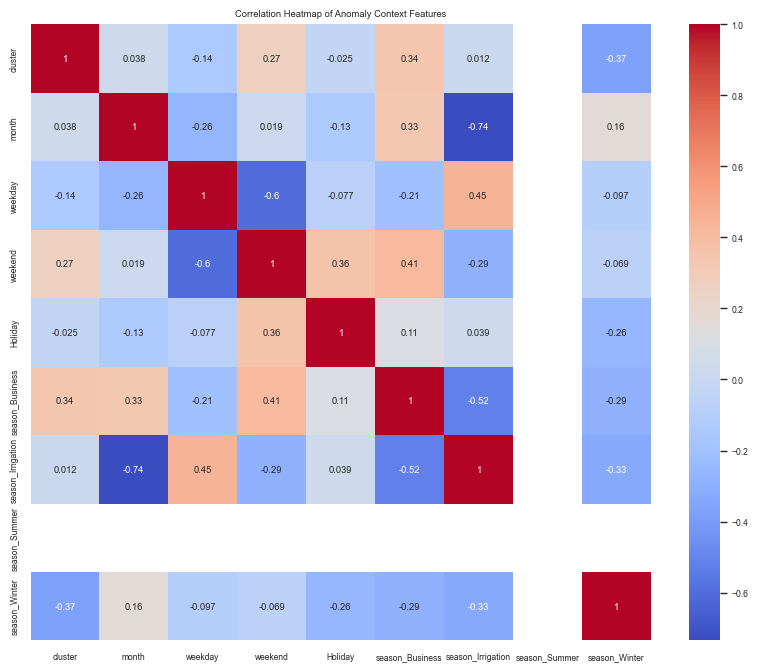

In [ ]:
# Calculate correlations between context columns
context_corr = anomalies_data[context_columns].corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(context_corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Anomaly Context Features")
plt.show()


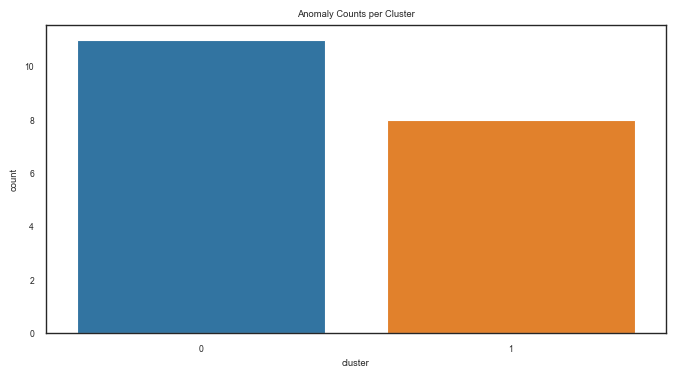

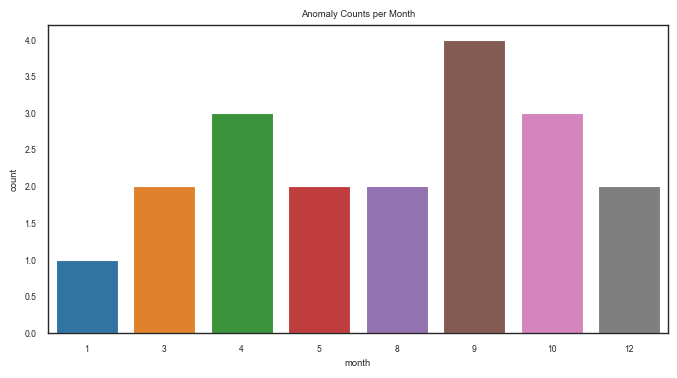

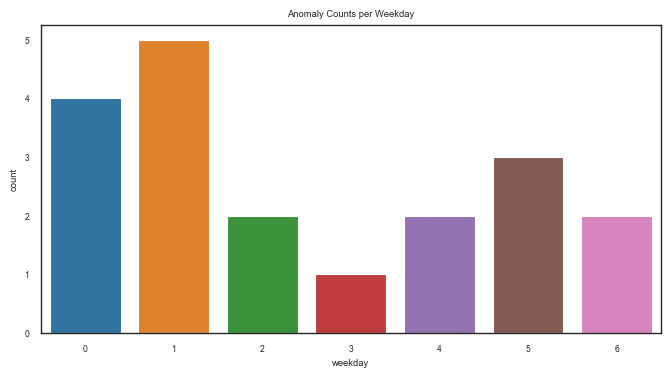

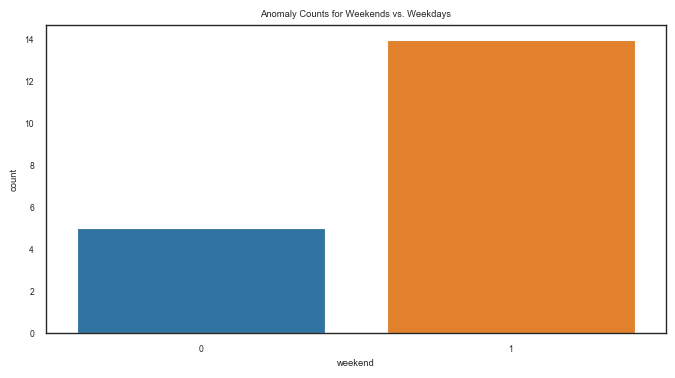

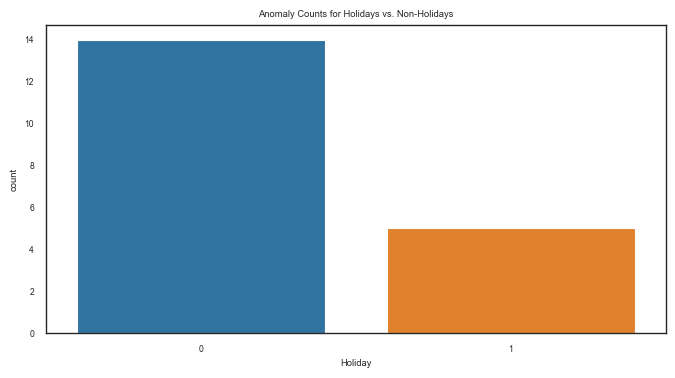

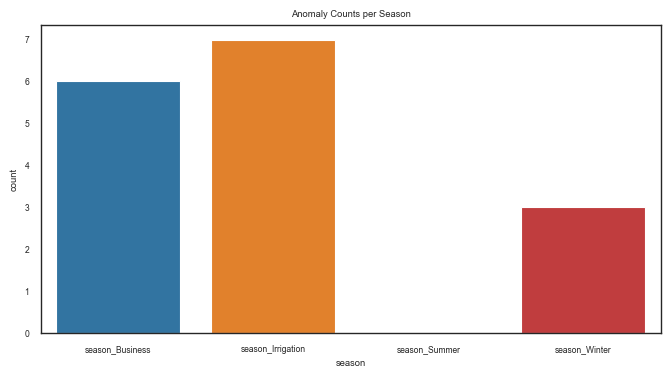

In [ ]:

# Anomaly counts per cluster
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='cluster')
plt.title('Anomaly Counts per Cluster')
plt.show()

# Anomaly counts per month
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='month')
plt.title('Anomaly Counts per Month')
plt.show()

# Anomaly counts per weekday
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='weekday')
plt.title('Anomaly Counts per Weekday')
plt.show()

# Anomaly counts per weekend
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='weekend')
plt.title('Anomaly Counts for Weekends vs. Weekdays')
plt.show()

# Anomaly counts per holiday
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='Holiday')
plt.title('Anomaly Counts for Holidays vs. Non-Holidays')
plt.show()

# Anomaly counts per season-related columns
season_columns = ['season_Business', 'season_Irrigation', 'season_Summer', 'season_Winter']
season_counts = anomalies_data[season_columns].sum().reset_index(name='count')
season_counts.columns = ['season', 'count']

plt.figure(figsize=(8, 4))
sns.barplot(data=season_counts, x='season', y='count')
plt.title('Anomaly Counts per Season')
plt.show()


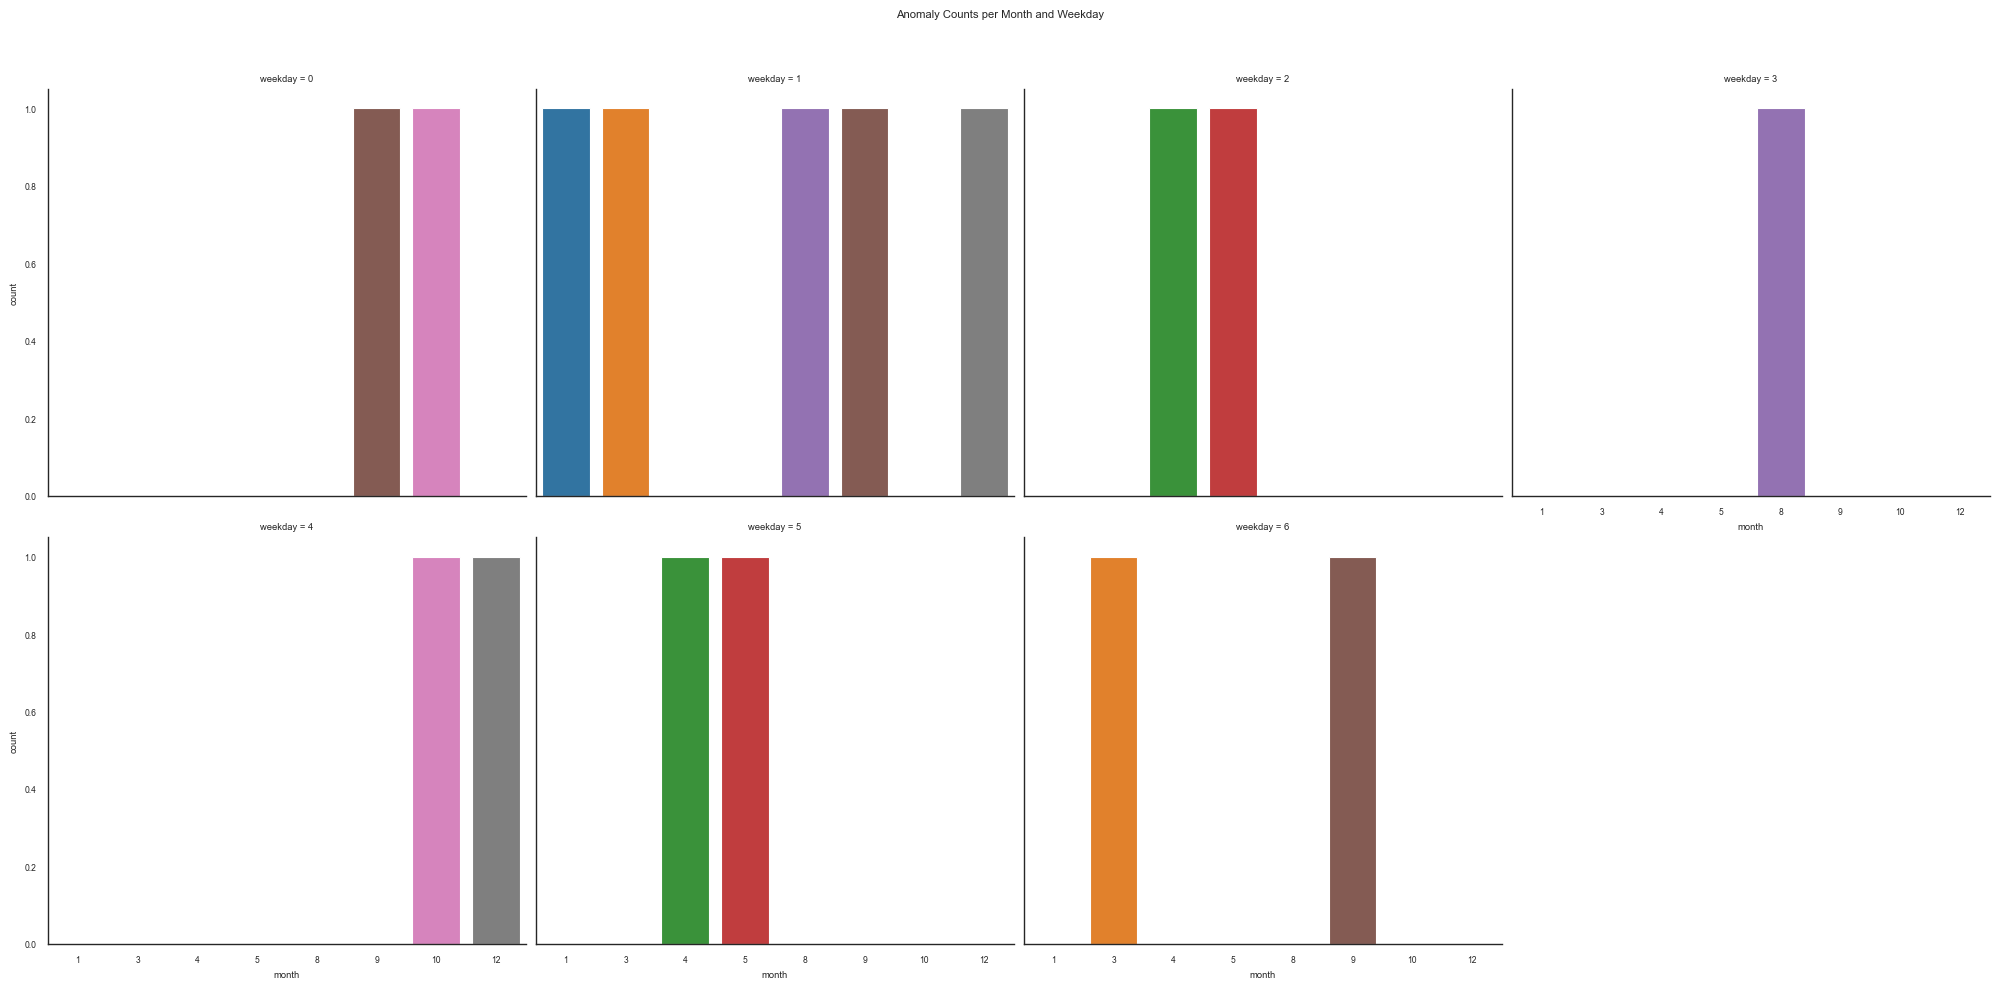

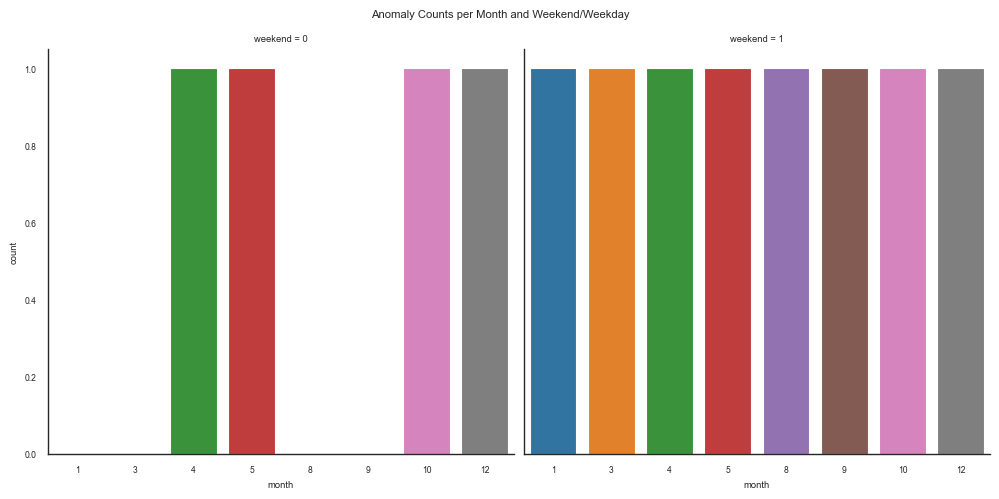

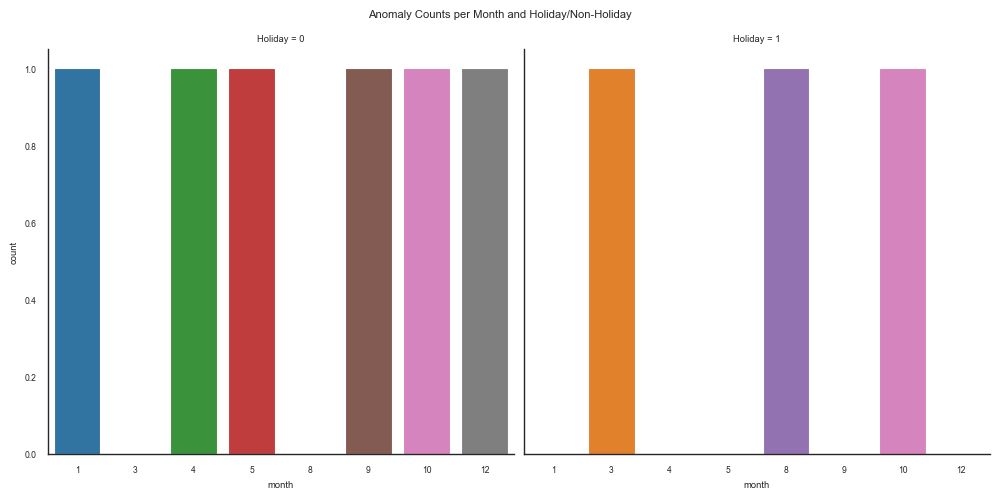

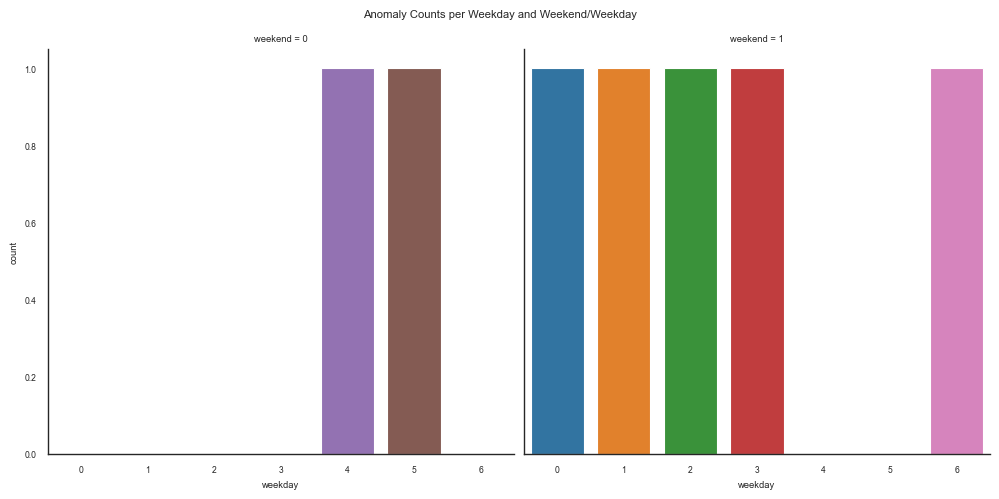

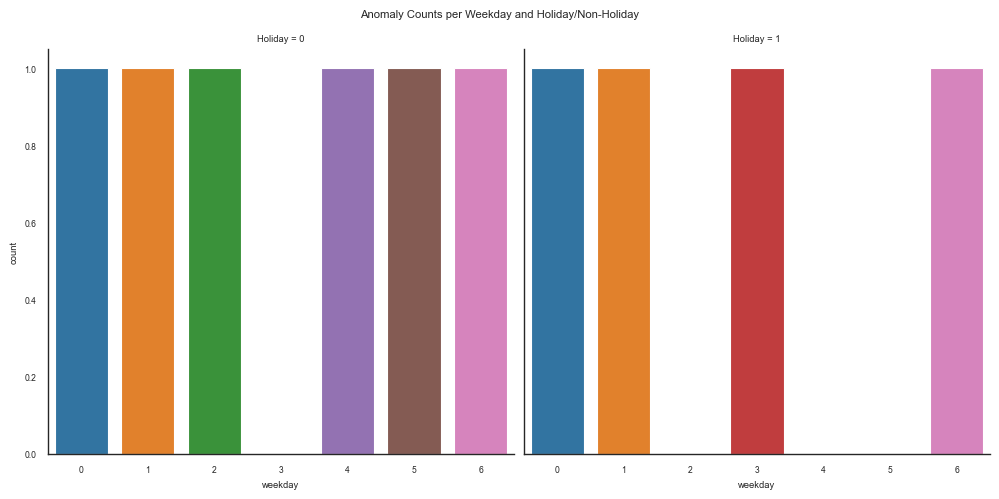

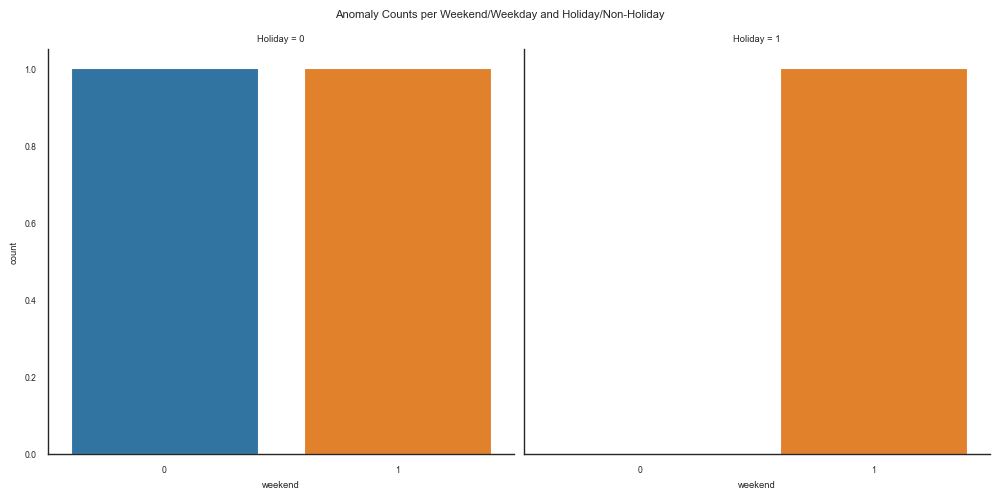

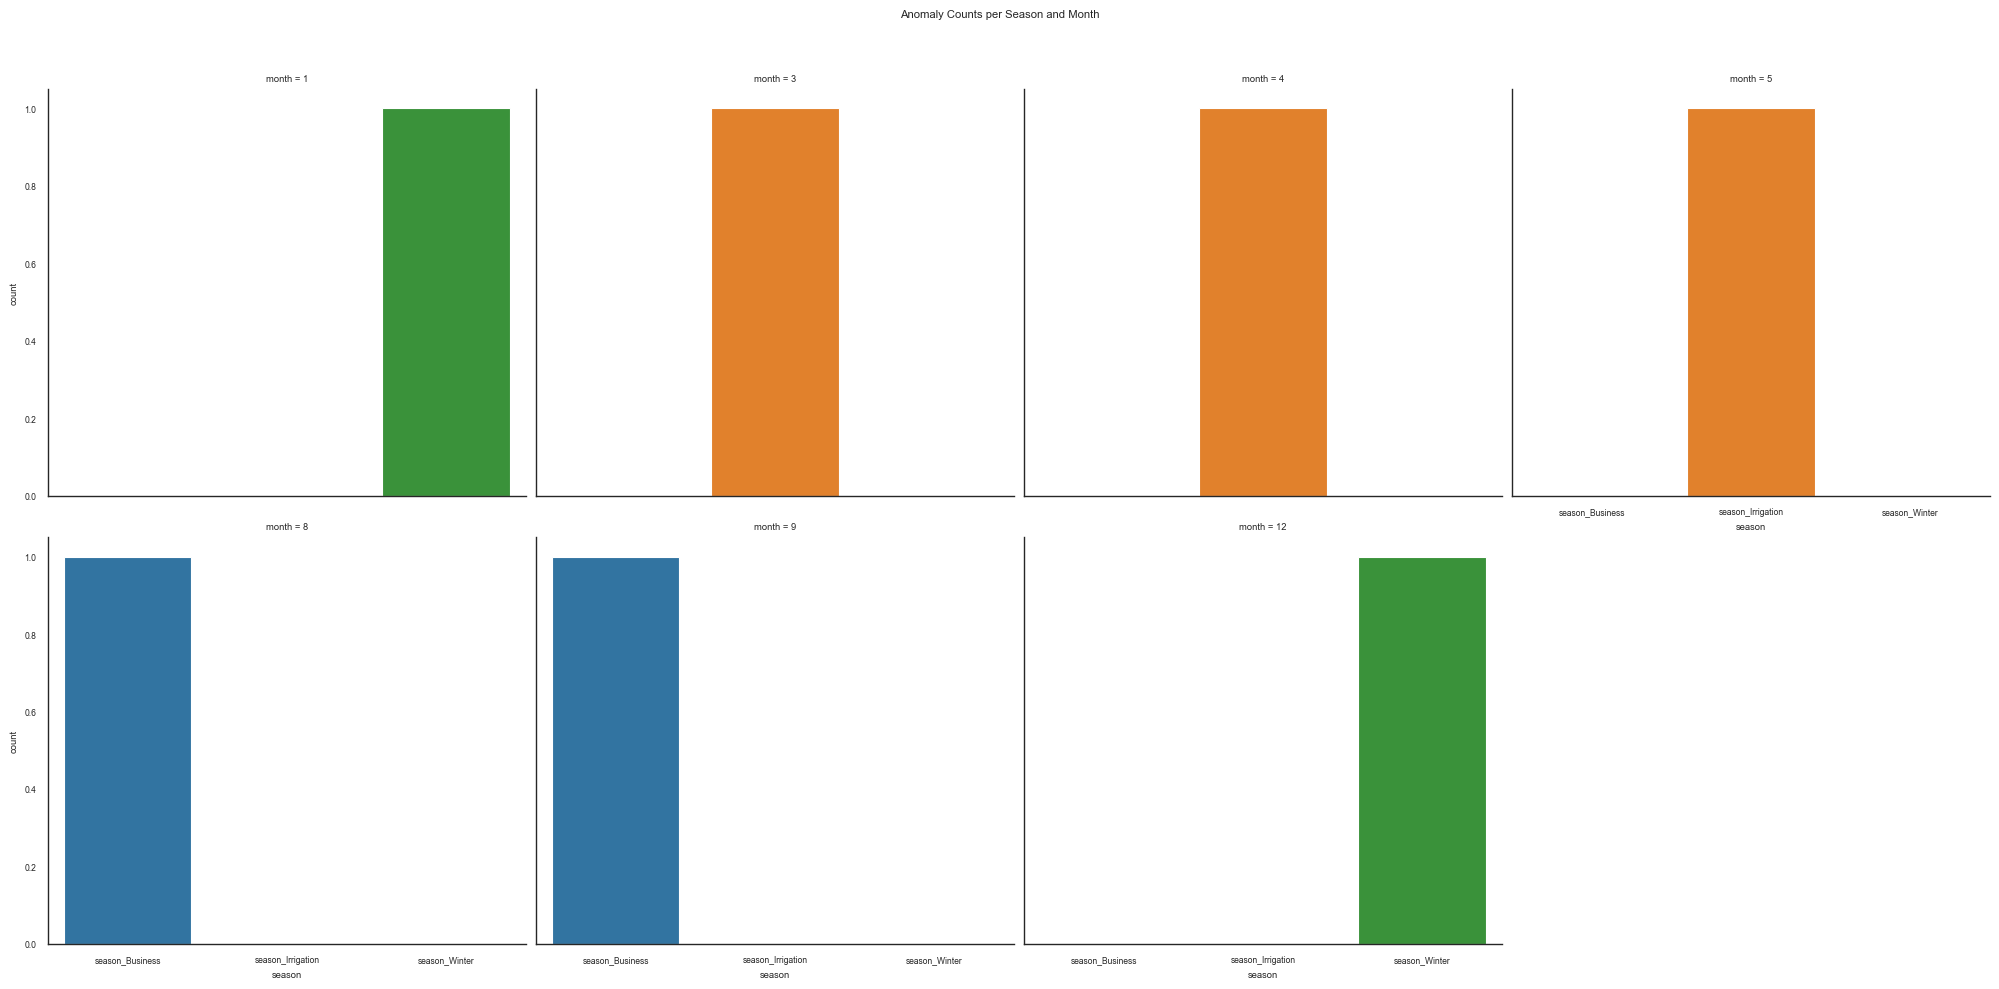

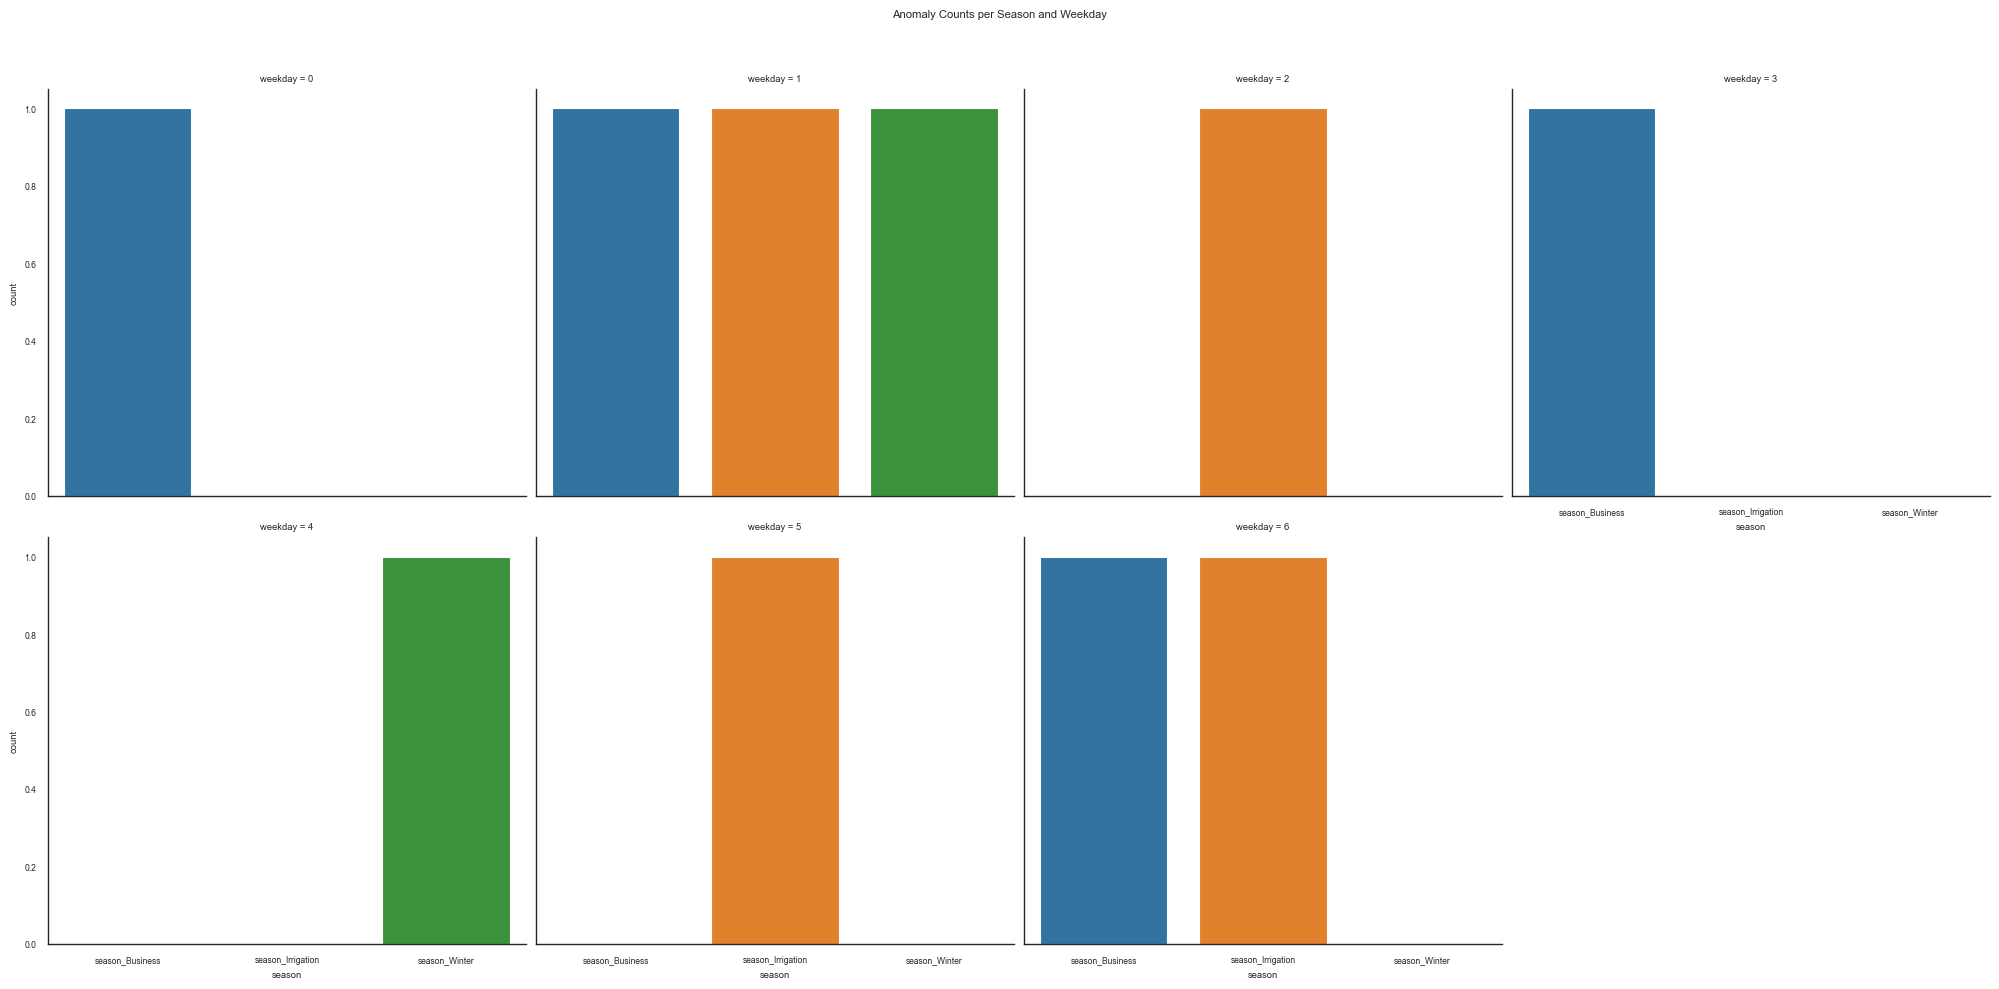

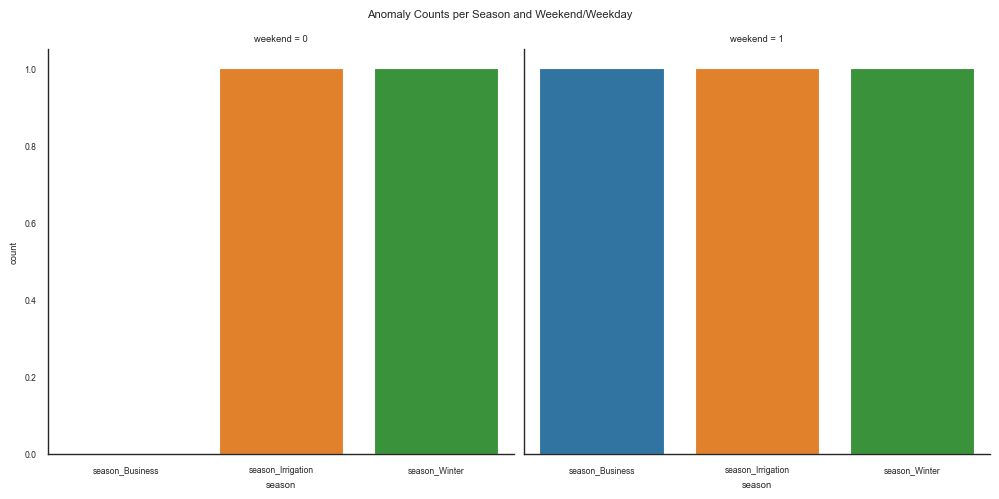

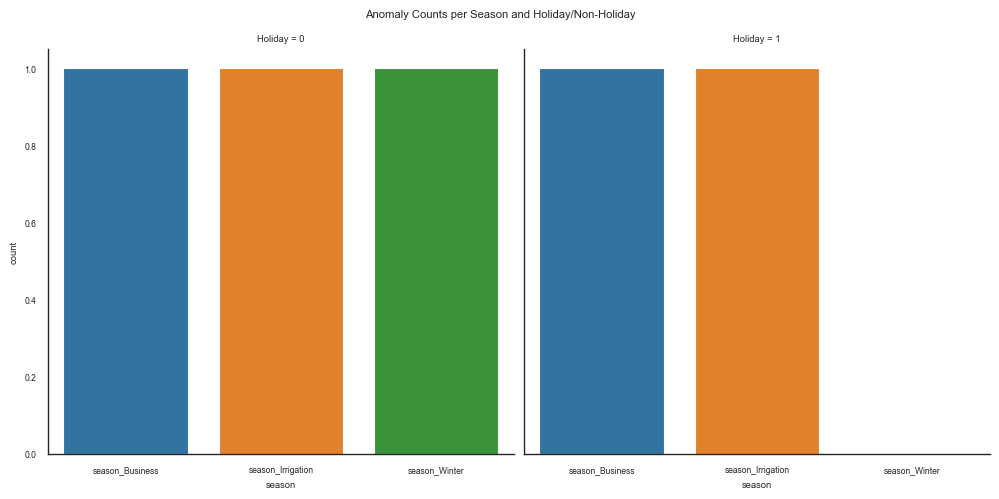

In [ ]:
# Relationship between month and other context columns
sns.catplot(data=context_counts, x='month', y='count', col='weekday', kind='bar', col_wrap=4)
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Month and Weekday')
plt.show()

sns.catplot(data=context_counts, x='month', y='count', col='weekend', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Month and Weekend/Weekday')
plt.show()

sns.catplot(data=context_counts, x='month', y='count', col='Holiday', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Month and Holiday/Non-Holiday')
plt.show()

# Relationship between weekday and other context columns
sns.catplot(data=context_counts, x='weekday', y='count', col='weekend', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Weekday and Weekend/Weekday')
plt.show()

sns.catplot(data=context_counts, x='weekday', y='count', col='Holiday', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Weekday and Holiday/Non-Holiday')
plt.show()

# Relationship between weekend and other context columns
sns.catplot(data=context_counts, x='weekend', y='count', col='Holiday', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Weekend/Weekday and Holiday/Non-Holiday')
plt.show()

# Relationship between season and other context columns
season_columns = ['season_Business', 'season_Irrigation', 'season_Summer', 'season_Winter']
season_df = anomalies_data.melt(id_vars=['cluster','month','weekday','weekend','Holiday'], value_vars=season_columns, var_name='season', value_name='count').query("count == 1")

sns.catplot(data=season_df, x='season', y='count', col='month', kind='bar', col_wrap=4)
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Season and Month')
plt.show()

sns.catplot(data=season_df, x='season', y='count', col='weekday', kind='bar', col_wrap=4)
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Season and Weekday')
plt.show()

sns.catplot(data=season_df, x='season', y='count', col='weekend', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Season and Weekend/Weekday')
plt.show()

sns.catplot(data=season_df, x='season', y='count', col='Holiday', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Season and Holiday/Non-Holiday')
plt.show()


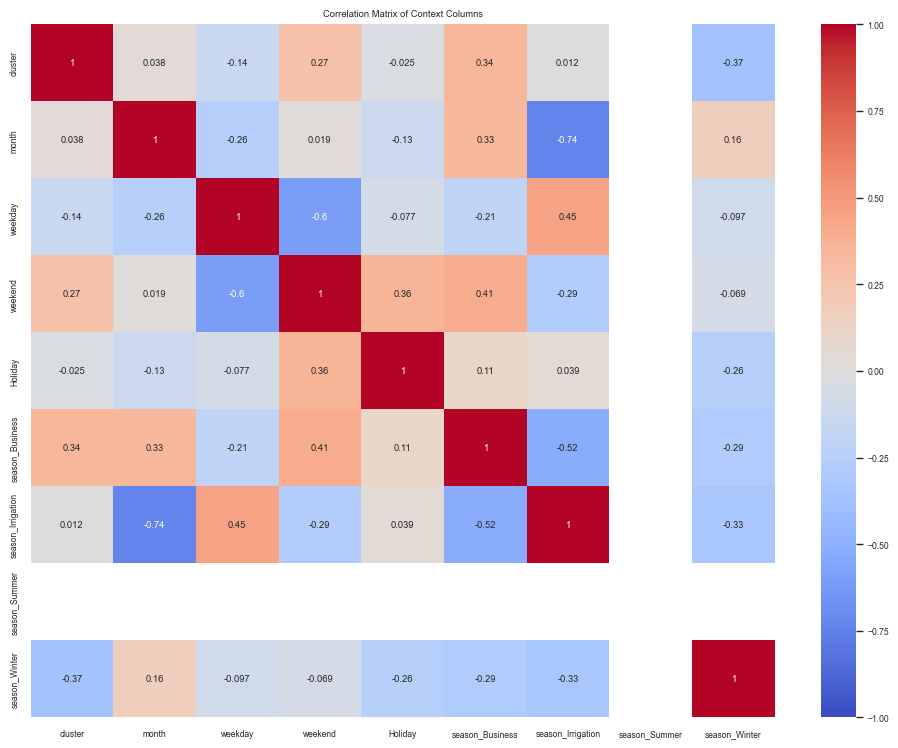

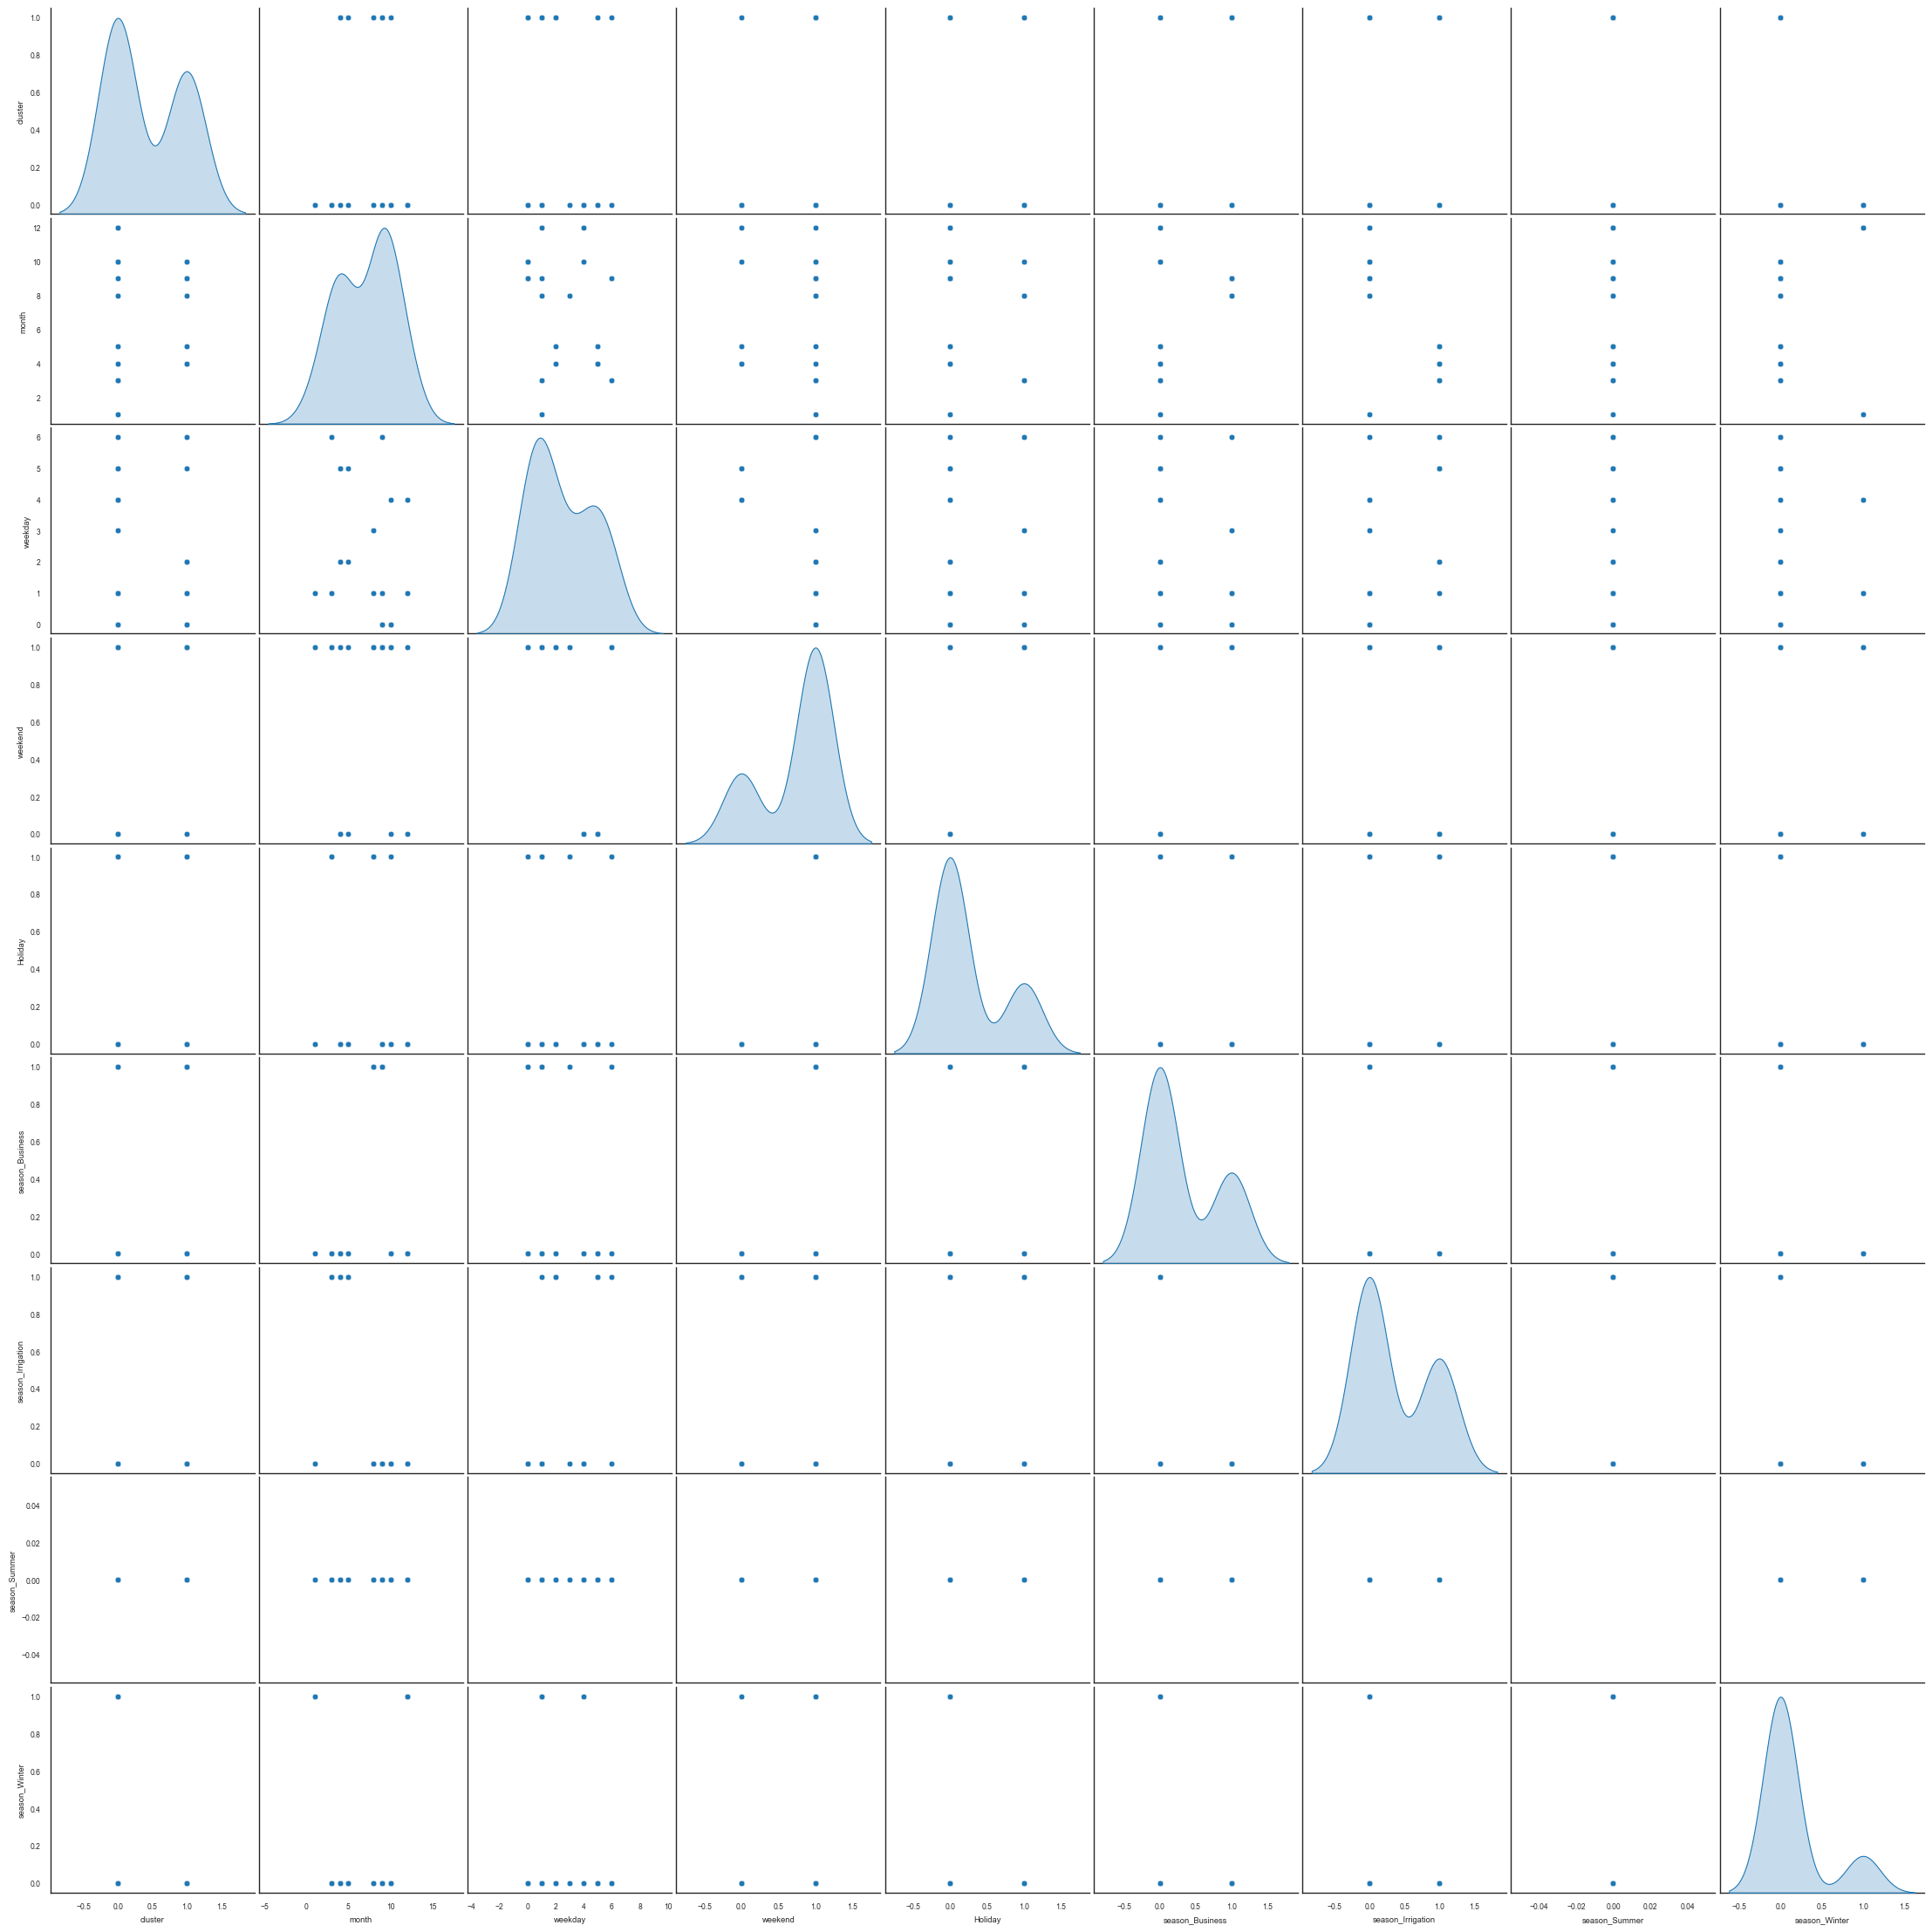

In [ ]:

# Calculate correlation coefficients between context columns
correlation_matrix = anomalies_data[context_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Context Columns')
plt.show()

# Create scatter plots for each pair of context columns
sns.pairplot(anomalies_data[context_columns], diag_kind='kde', markers='o')
plt.show()


**Seasonal demand patterns:** Bangladesh has distinct seasonal variations, with summer being the hottest and most humid period. People tend to use more electricity during summer for cooling purposes, which may lead to higher energy consumption and potential anomalies.

**Hypothesis 1:** Anomalies in energy consumption are more likely to occur during summer due to increased demand for cooling.

**Industrial and agricultural activities:** The energy consumption patterns of the industrial and agricultural sectors can influence the overall energy consumption. For example, irrigation activities usually increase during certain periods, which may lead to higher energy consumption.

**Hypothesis 2:** Anomalies in energy consumption might be associated with periods of high industrial or agricultural activities.

**Holidays and special events:** Energy consumption may vary during holidays and special events due to changes in people's daily routines and commercial activities. For instance, during religious festivals, there could be increased energy consumption due to celebrations, gatherings, and lighting.

**Hypothesis 3:** Anomalies in energy consumption might be related to holidays or special events.

**Infrastructure and maintenance issues:** Power plants and energy infrastructure may experience maintenance issues or capacity constraints, which could lead to temporary changes in energy consumption patterns.

**Hypothesis 4:** Anomalies in energy consumption might be associated with infrastructure or maintenance issues.

**Weather-related factors:** Extreme weather conditions, such as storms, floods, or heatwaves, can affect energy consumption patterns. For example, during a heatwave, people may use more electricity for cooling, leading to higher energy consumption.